In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
sns.set_theme()
# For the image quality of the graphic. 
sns.set(rc={"figure.dpi":600})
# For the size of the graphics
sns.set(rc = {"figure.figsize":(6,3)})
sns.set(font_scale=0.5)

In [53]:
# Loading dataSets
appRec = pd.read_csv('records/application_record.csv')
creRec = pd.read_csv('records/credit_record.csv')

In [54]:
appRec.shape

(438557, 18)

In [56]:
appRec.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

In [57]:
print(f'Application record file contain {appRec.shape[0]} rows and {appRec.shape[1]} columns with {appRec.shape[0] - appRec.ID.nunique() } dupplicated IDs ')

Application record file contain 438557 rows and 18 columns with 47 dupplicated IDs 


In [58]:
creRec.head()

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

In [59]:
print(f'Credit_record file contain {creRec.shape[0]} rows and {creRec.shape[1]} columns')

Credit_record file contain 1048575 rows and 3 columns


- We have two data sets that are related with ID columns.   
- Since our data sets it isn't labeled, we need to create labes out selfs.  
- As hinted in the tasks labels need to be 'good' or 'bad' in other worlds 0 or 1 classification problem.  
- Let's start working creRec and try to establish understanding of credit history from different clients.  

Columns definitions:  

ID             : Represent client unique identifier  
MONTHS_BALANCE : The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on  
STATUS         : Columns with multiple values represented bellow.   




STATUS: 

0: 1-29 days past due  
1: 30-59 days past due  
2: 60-89 days overdue  
3: 90-119 days overdue  
4: 120-149 days overdue  
5: Overdue or bad debts, write-offs for more than 150 days  
C: paid off that month  
X: No loan for the month  



for our sake of understanding it's better to change the status based on the risk level for example:  

- 0 will represent STATUS C and X since they won't represent risk.  
- 1 will represent the current STATUS 0   
- etc..  

In [62]:
replacement = { str(i):i+1 for i in range(6)}
replacement.update({'X':0, 'C':0})

In [63]:

creRec.STATUS = creRec.STATUS.replace(replacement)

In [64]:
creRec.head()

ID  MONTHS_BALANCE  STATUS
0  5001711               0       0
1  5001711              -1       1
2  5001711              -2       1
3  5001711              -3       1
4  5001712               0       0

In [65]:
# Let's see the worst scenario of the population
aggCredit = (pd
             .DataFrame(creRec.groupby('ID').agg({'STATUS':'max'}).STATUS.value_counts())
             .reset_index()
             .rename({'index':'worst_status','STATUS':'count'},axis=1)
            )

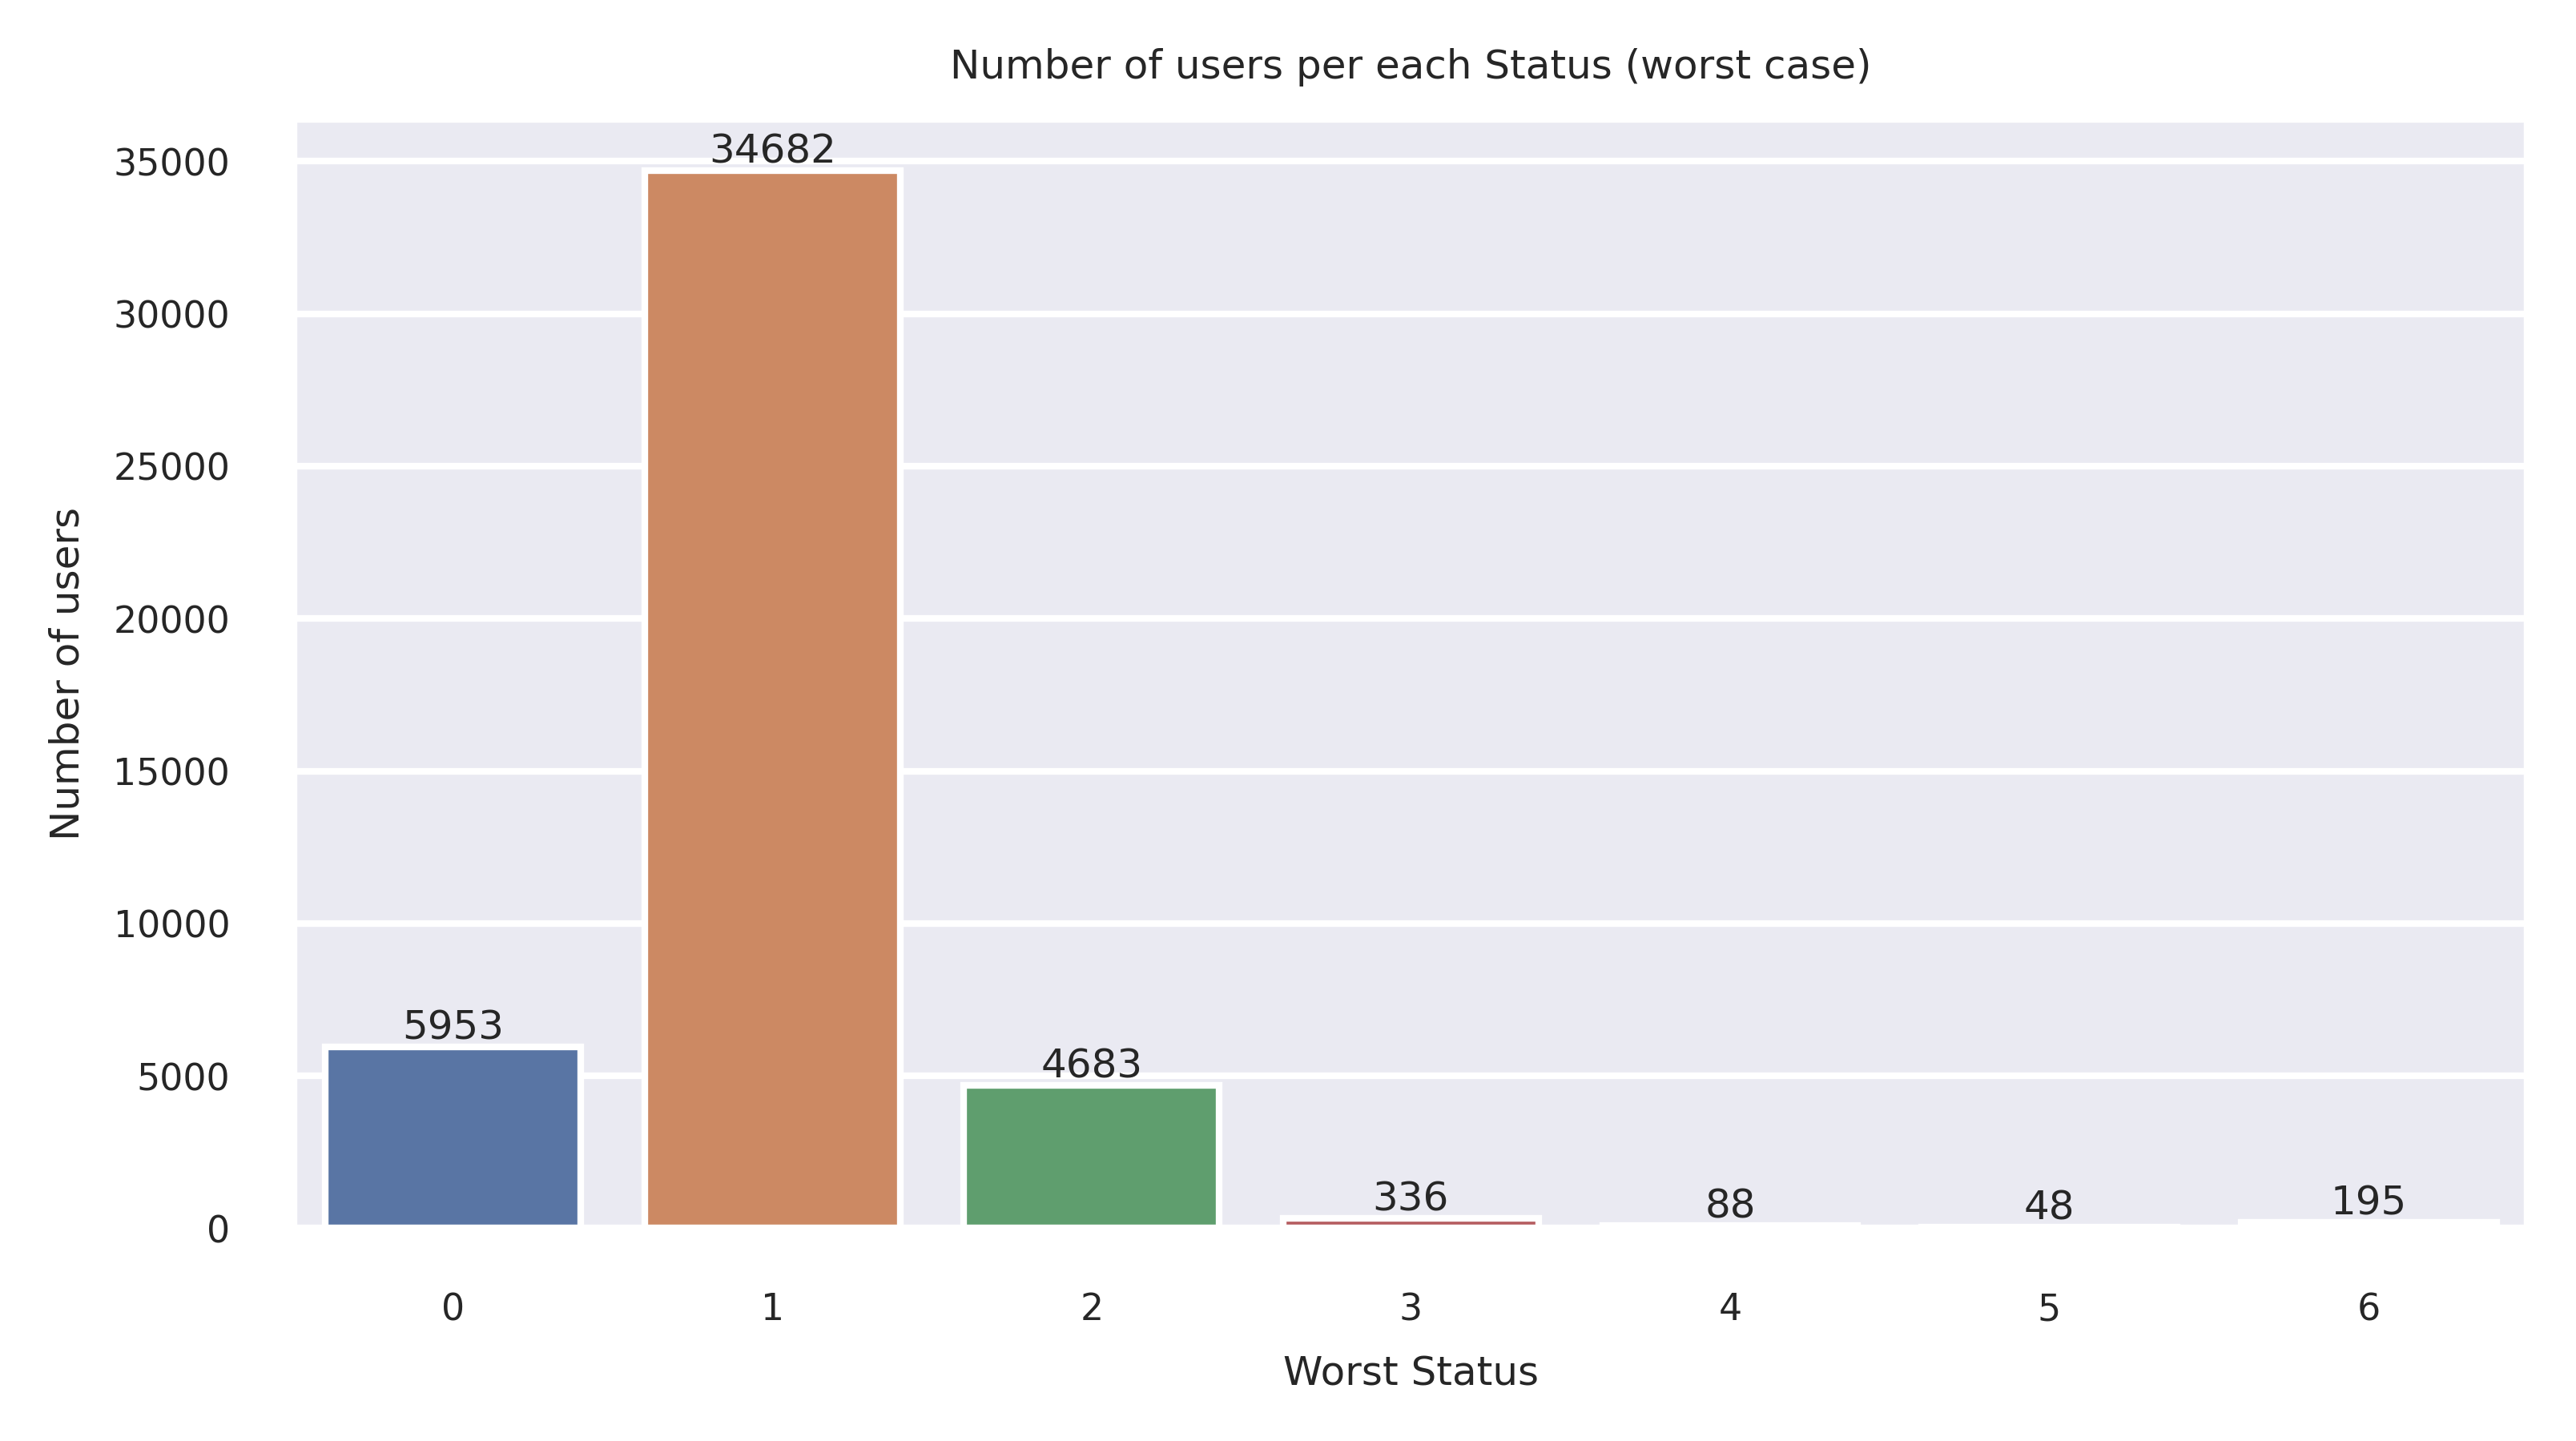

In [66]:
plot = sns.barplot(x = "worst_status", y = "count", data = aggCredit)
plot.set(xlabel='Worst Status', ylabel='Number of users')
plot.set_title('Number of users per each Status (worst case)')
for i in plot.containers:
    plot.bar_label(i,)

The plot above show that users that had at most Status 1 (-29 days past due) represent ~ 88 % of our dataset $\frac{5953 + 34682 }{45985}  $.  
And in case we consider that Status 2 is good debt then we will have $ \frac{5953 + 34682 + 4683}{45985}   $  ~ 98%  

We can't cosider user with worst case status 1 as bad debt since it represent the majority of our data set and delay of 1-29 days won't hurst the busniess since the user will pay high interest on the debt.  
For users worst Status 2  if we consider them as bad debt than ou target base will be at ~ 12 % but since it defined as (30-59 days past due) and not overdue we will accept them as good debt.  


In [69]:
#Creating Traget. 
Target = (creRec
          .groupby('ID')
          .agg({'STATUS':np.max})
          .reset_index()
          .assign(Target = lambda x: [int(i>2) for i in x.STATUS])
          .drop(columns = ['STATUS'])
         )

In [70]:
Target.Target.value_counts()
# Everything seem correct

0    45318
1      667
Name: Target, dtype: int64

In [71]:
# Let's merge with application record data set using inner join since we can't train on data set that doesn't contain labels (using supervised models as suggested in the competition)
newAppRec = appRec.merge(Target,on='ID',how='inner')

In [72]:
newAppRec

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      5008804           M            Y               Y             0   
1      5008805           M            Y               Y             0   
2      5008806           M            Y               Y             0   
3      5008808           F            N               Y             0   
4      5008809           F            N               Y             0   
...        ...         ...          ...             ...           ...   
36452  5149828           M            Y               Y             0   
36453  5149834           F            N               Y             0   
36454  5149838           F            N               Y             0   
36455  5150049           F            N               Y             0   
36456  5150337           M            N               Y             0   

       AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.0               Working               Higher education   
1              427500.0               Working               Higher education   
2              112500.0               Working  Secondary / secondary special   
3              270000.0  Commercial associate  Secondary / secondary special   
4              270000.0  Commercial associate  Secondary / secondary special   
...                 ...                   ...                            ...   
36452          315000.0               Working  Secondary / secondary special   
36453          157500.0  Commercial associate               Higher education   
36454          157500.0             Pensioner               Higher education   
36455          283500.0               Working  Secondary / secondary special   
36456          112500.0               Working  Secondary / secondary special   

         NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0            Civil marriage   Rented apartment      -12005          -4542   
1            Civil marriage   Rented apartment      -12005          -4542   
2                   Married  House / apartment      -21474          -1134   
3      Single / not married  House / apartment      -19110          -3051   
4      Single / not married  House / apartment      -19110          -3051   
...                     ...                ...         ...            ...   
36452               Married  House / apartment      -17348          -2420   
36453               Married  House / apartment      -12387          -1325   
36454               Married  House / apartment      -12387          -1325   
36455               Married  House / apartment      -17958           -655   
36456  Single / not married   Rented apartment       -9188          -1193   

       FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0               1                1           0           0             NaN   
1               1                1           0           0             NaN   
2               1                0           0           0  Security staff   
3               1                0           1           1     Sales staff   
4               1                0           1           1     Sales staff   
...           ...              ...         ...         ...             ...   
36452           1                0           0           0        Managers   
36453           1                0           1           1  Medicine staff   
36454           1                0           1           1  Medicine staff   
36455           1                0           0           0     Sales staff   
36456           1                0           0           0        Laborers   

       CNT_FAM_MEMBERS  Target  
0                  2.0       0  
1                  2.0       0  
2                  2.0       0  
3                  1.0       0  
4                  1.0       0  
...                ...     ...  
36452              2.0       1  
36453              2.0       1  
36454          

We didn't introduce any information from creRec because it was meant to do data labeling,
also because we want to predict if the costumer will **good** or **bad** client only from using **appRec** data.  

Other critical reason is we want to add variables from **creRec** that step will introduce data **leakage** to our model and it will **overfit**.  


## Exploratory data analysis

Check *NaN* values

In [75]:
for c in newAppRec.columns:
    na = newAppRec[c].isna().sum()
    if na != 0:
        print(f'Column {c} contain: {na} Na s')

Column OCCUPATION_TYPE contain: 11323 Na s


~32% of columns **OCCUPATION_TYPE** doesn't contain information
let's see if we can addresse this issue

In [77]:
newAppRec.OCCUPATION_TYPE.value_counts()

Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: OCCUPATION_TYPE, dtype: int64

In [78]:
newAppRec.OCCUPATION_TYPE.fillna('Not mentioned',inplace=True)
newAppRec.Target = newAppRec.Target.astype(str)

Text(0.5, 1.0, 'Clients income distrubution by occupation type')

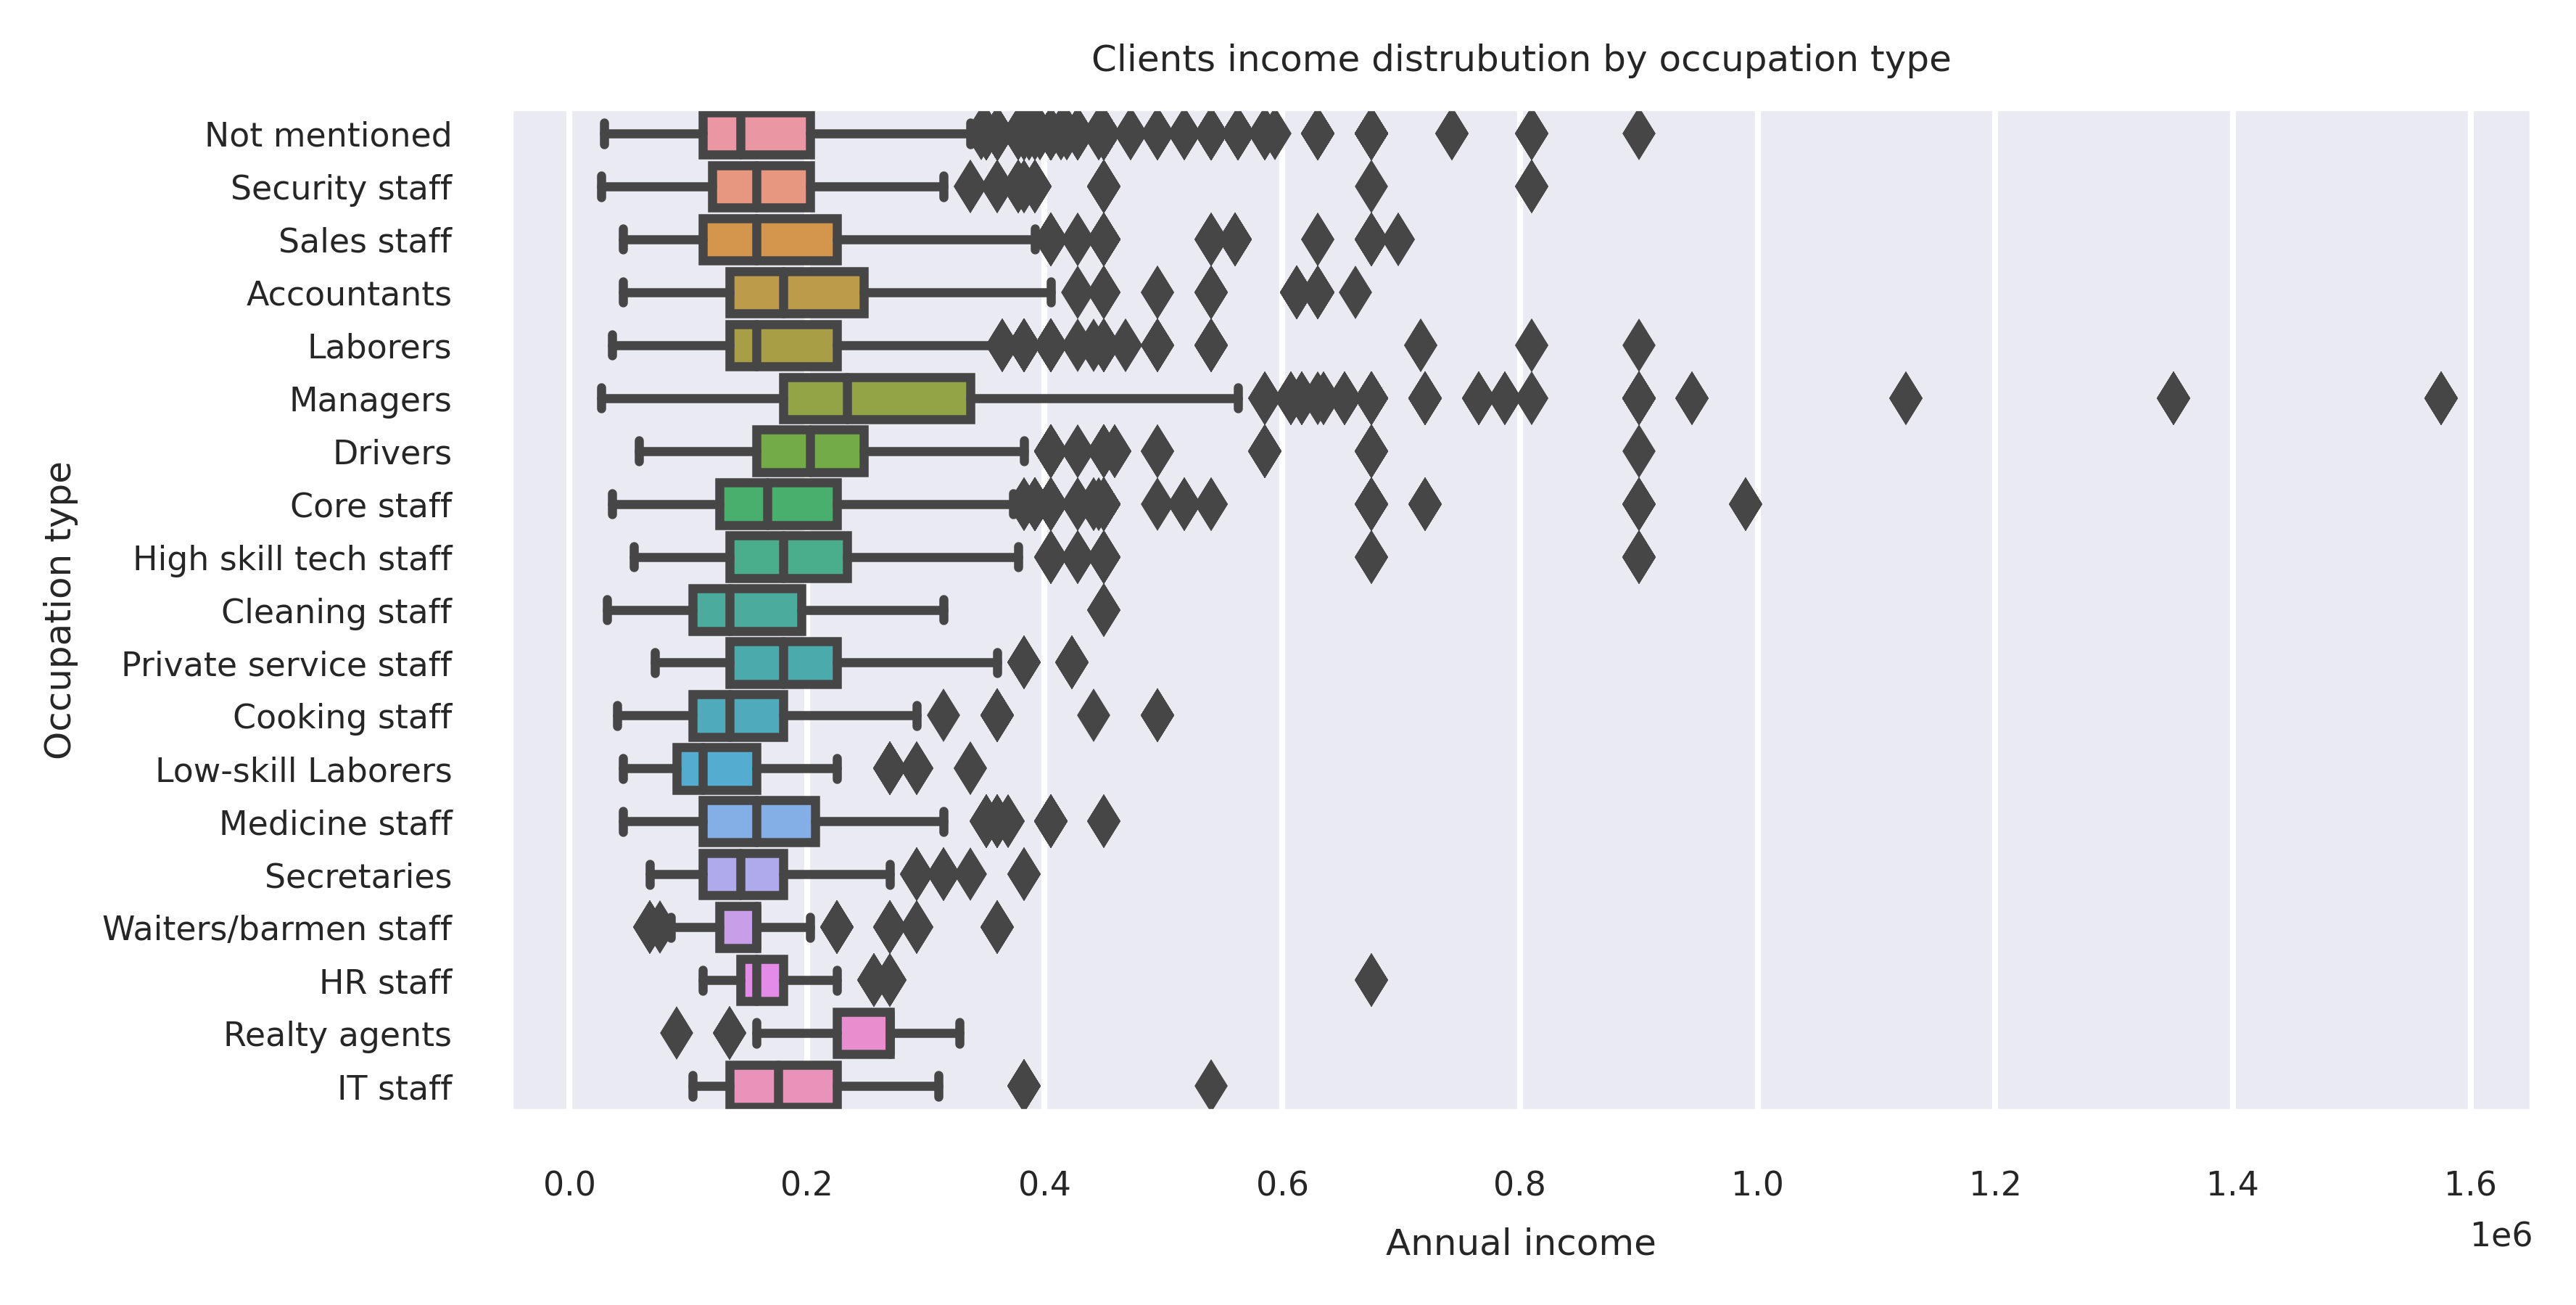

In [79]:
plot = sns.boxplot(data=newAppRec, x="AMT_INCOME_TOTAL", y="OCCUPATION_TYPE")
plot.set(xlabel='Annual income', ylabel='Occupation type')
plot.set_title('Clients income distrubution by occupation type')

based on box plot above the distribution of NA's value is mostly similar to Security Staff but it contain alot of outliers unlike the other. 
we will se later if we ill merge this variable with other or keep as it is.


Text(0.5, 1.0, 'Clients income distrubution by target')

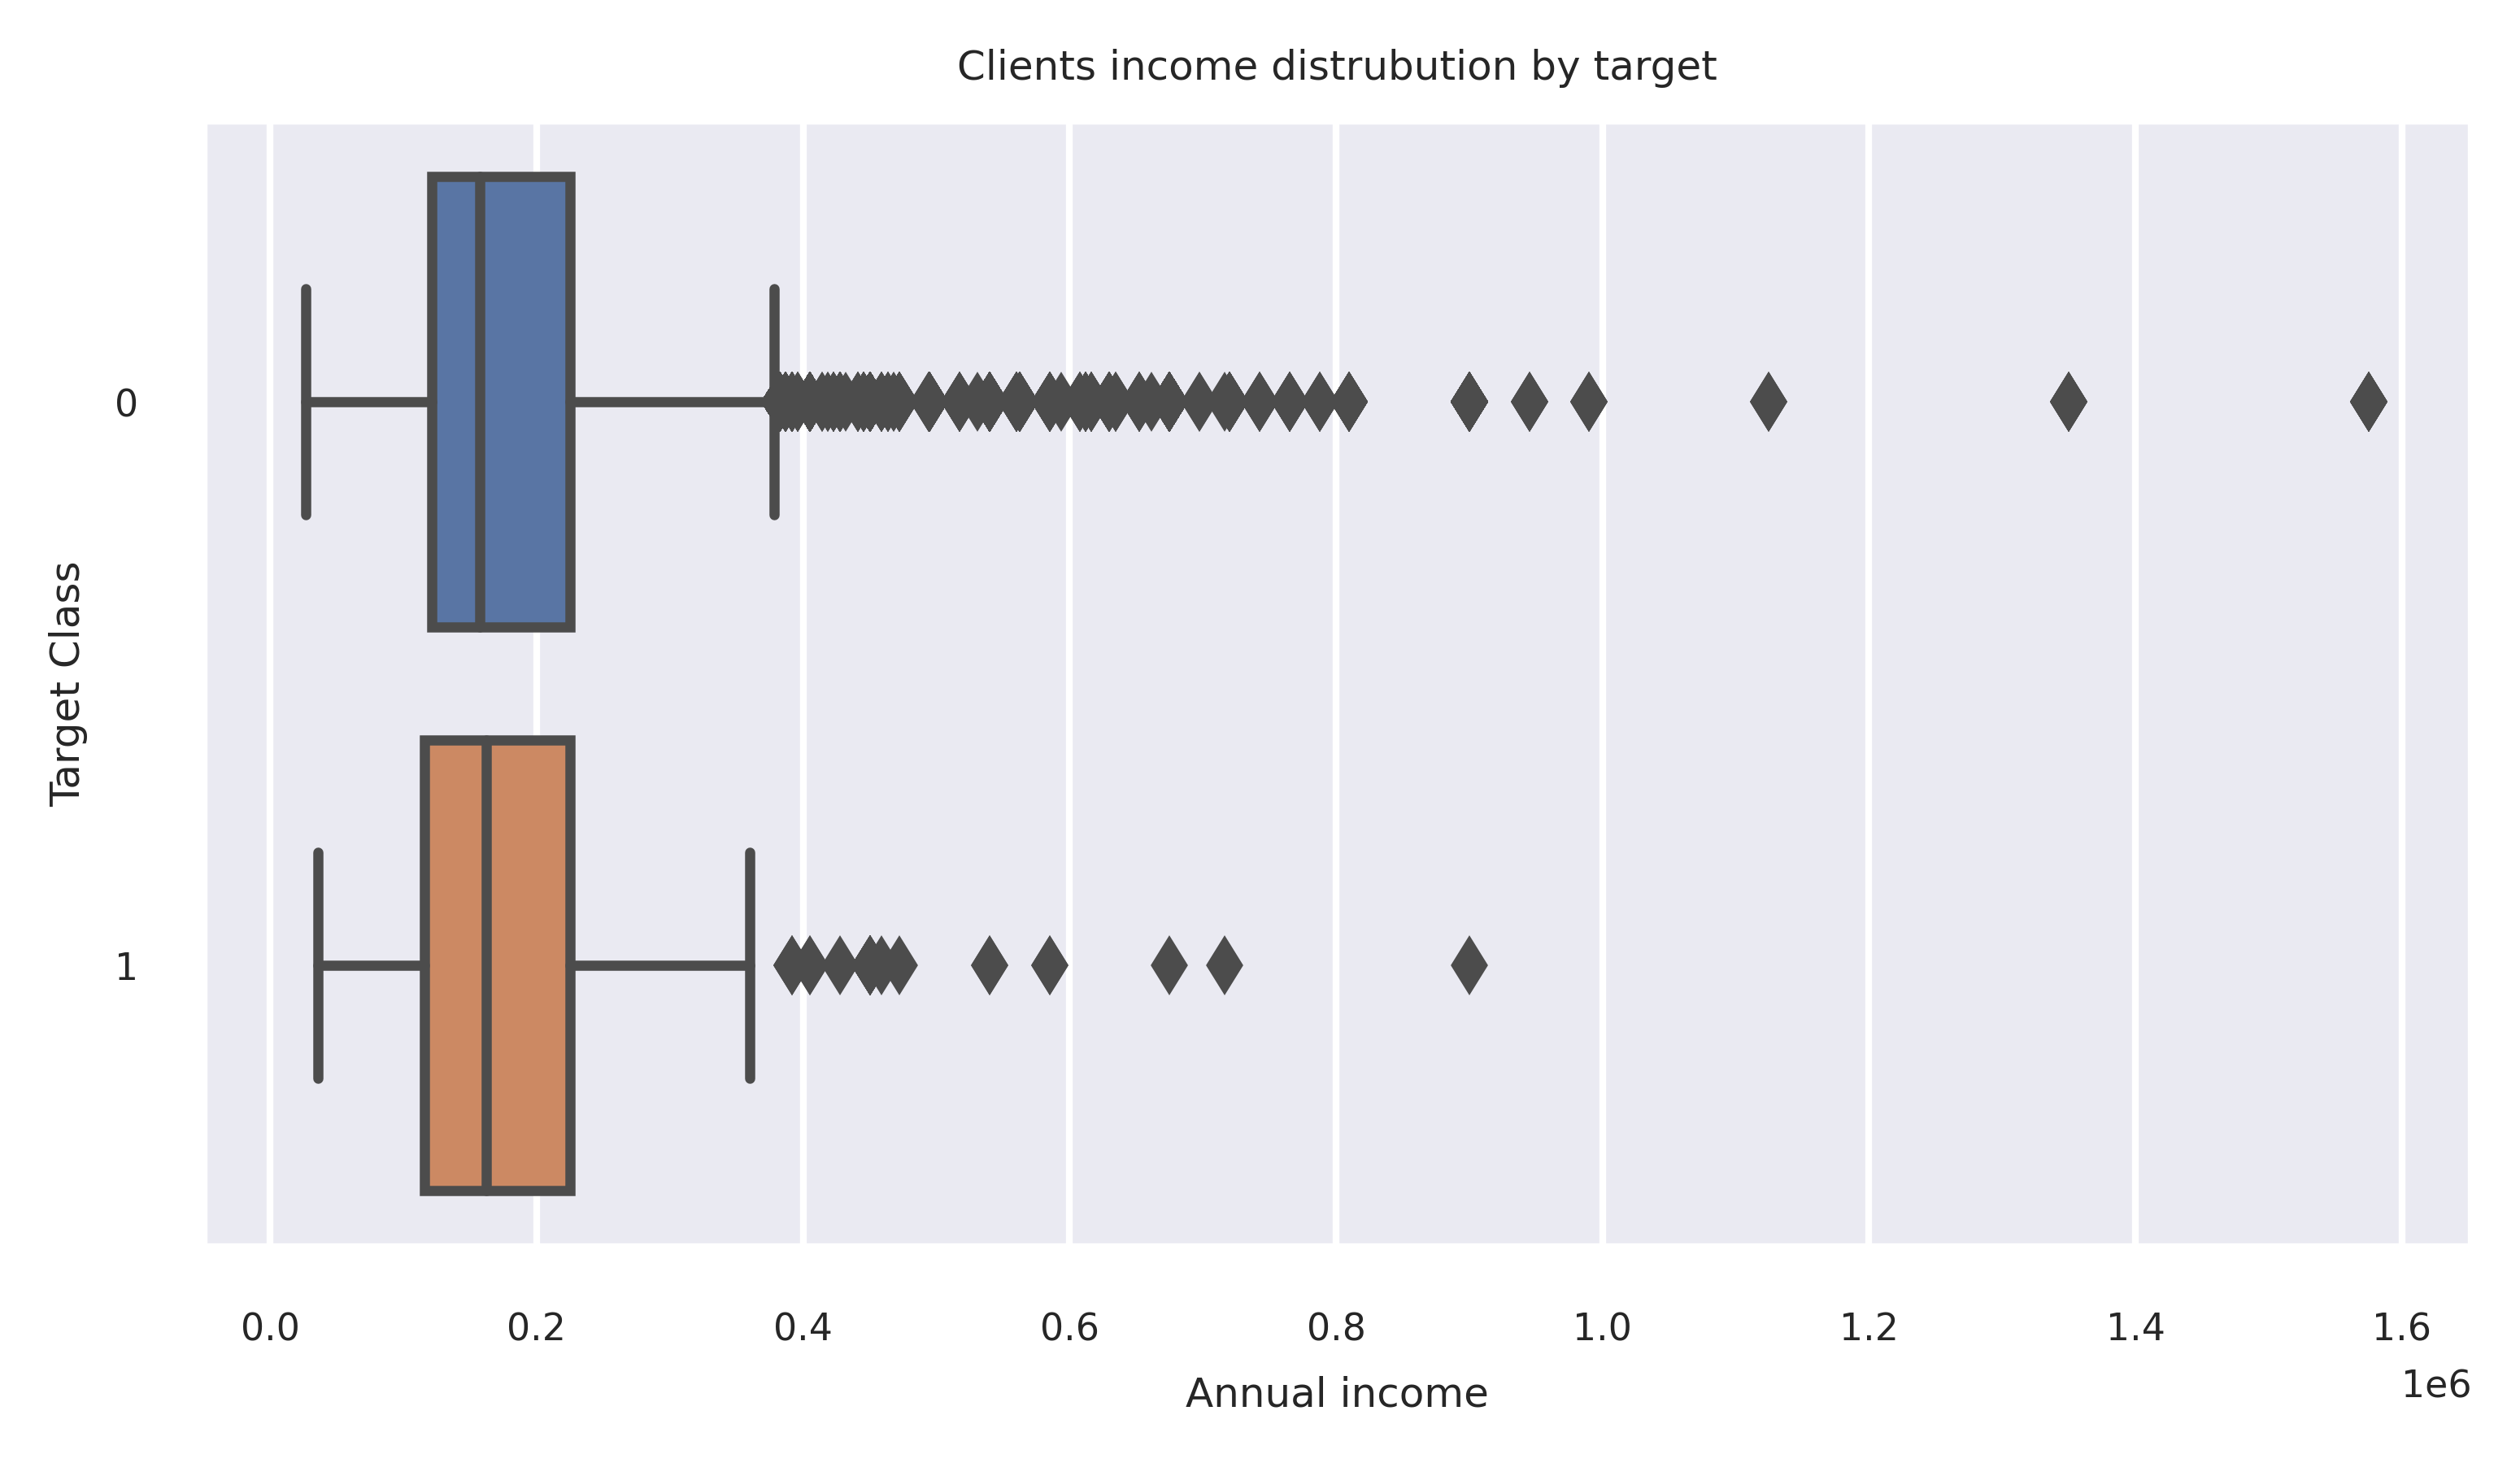

In [81]:
plot = sns.boxplot(data=newAppRec, x="AMT_INCOME_TOTAL", y="Target")
plot.set(xlabel='Annual income', ylabel='Target Class')
plot.set_title('Clients income distrubution by target')


In [82]:
newAppRec

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      5008804           M            Y               Y             0   
1      5008805           M            Y               Y             0   
2      5008806           M            Y               Y             0   
3      5008808           F            N               Y             0   
4      5008809           F            N               Y             0   
...        ...         ...          ...             ...           ...   
36452  5149828           M            Y               Y             0   
36453  5149834           F            N               Y             0   
36454  5149838           F            N               Y             0   
36455  5150049           F            N               Y             0   
36456  5150337           M            N               Y             0   

       AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.0               Working               Higher education   
1              427500.0               Working               Higher education   
2              112500.0               Working  Secondary / secondary special   
3              270000.0  Commercial associate  Secondary / secondary special   
4              270000.0  Commercial associate  Secondary / secondary special   
...                 ...                   ...                            ...   
36452          315000.0               Working  Secondary / secondary special   
36453          157500.0  Commercial associate               Higher education   
36454          157500.0             Pensioner               Higher education   
36455          283500.0               Working  Secondary / secondary special   
36456          112500.0               Working  Secondary / secondary special   

         NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0            Civil marriage   Rented apartment      -12005          -4542   
1            Civil marriage   Rented apartment      -12005          -4542   
2                   Married  House / apartment      -21474          -1134   
3      Single / not married  House / apartment      -19110          -3051   
4      Single / not married  House / apartment      -19110          -3051   
...                     ...                ...         ...            ...   
36452               Married  House / apartment      -17348          -2420   
36453               Married  House / apartment      -12387          -1325   
36454               Married  House / apartment      -12387          -1325   
36455               Married  House / apartment      -17958           -655   
36456  Single / not married   Rented apartment       -9188          -1193   

       FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0               1                1           0           0   Not mentioned   
1               1                1           0           0   Not mentioned   
2               1                0           0           0  Security staff   
3               1                0           1           1     Sales staff   
4               1                0           1           1     Sales staff   
...           ...              ...         ...         ...             ...   
36452           1                0           0           0        Managers   
36453           1                0           1           1  Medicine staff   
36454           1                0           1           1  Medicine staff   
36455           1                0           0           0     Sales staff   
36456           1                0           0           0        Laborers   

       CNT_FAM_MEMBERS Target  
0                  2.0      0  
1                  2.0      0  
2                  2.0      0  
3                  1.0      0  
4                  1.0      0  
...                ...    ...  
36452              2.0      1  
36453              2.0      1  
36454              2.0  

Both **DAYS_BIRTH** and **DAYS_EMPLOYED** are in negatif let transform **DAYS_BIRTH** to **age** and **DAYS_EMPLOYED** to months

In [83]:
newAppRec = (newAppRec
             .assign(age = lambda x:[abs(int(i/365)) for i in x.DAYS_BIRTH],
                             unemployed = lambda x:[int(i>0) for i in x.DAYS_EMPLOYED],
                             monthEmployed = lambda x:[abs(int(min(i,0)/30))  for i in x.DAYS_EMPLOYED  ]
                            )
             .drop(columns = ['DAYS_EMPLOYED','DAYS_BIRTH'])
            )

In [84]:
newAppRec.set_index('ID',inplace=True)
newAppRec.head()

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   
5008808           F            N               Y             0   
5008809           F            N               Y             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
ID                                                
5008804          427500.0               Working   
5008805          427500.0               Working   
5008806          112500.0               Working   
5008808          270000.0  Commercial associate   
5008809          270000.0  Commercial associate   

                   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
ID                                                             
5008804               Higher education        Civil marriage   
5008805               Higher education        Civil marriage   
5008806  Secondary / secondary special               Married   
5008808  Secondary / secondary special  Single / not married   
5008809  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  \
ID                                                                    
5008804   Rented apartment           1                1           0   
5008805   Rented apartment           1                1           0   
5008806  House / apartment           1                0           0   
5008808  House / apartment           1                0           1   
5008809  House / apartment           1                0           1   

         FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS Target  age  unemployed  \
ID                                                                             
5008804           0   Not mentioned              2.0      0   32           0   
5008805           0   Not mentioned              2.0      0   32           0   
5008806           0  Security staff              2.0      0   58           0   
5008808           1     Sales staff              1.0      0   52           0   
5008809           1     Sales staff              1.0      0   52           0   

         monthEmployed  
ID                      
5008804            151  
5008805            151  
5008806             37  
5008808            101  
5008809            101

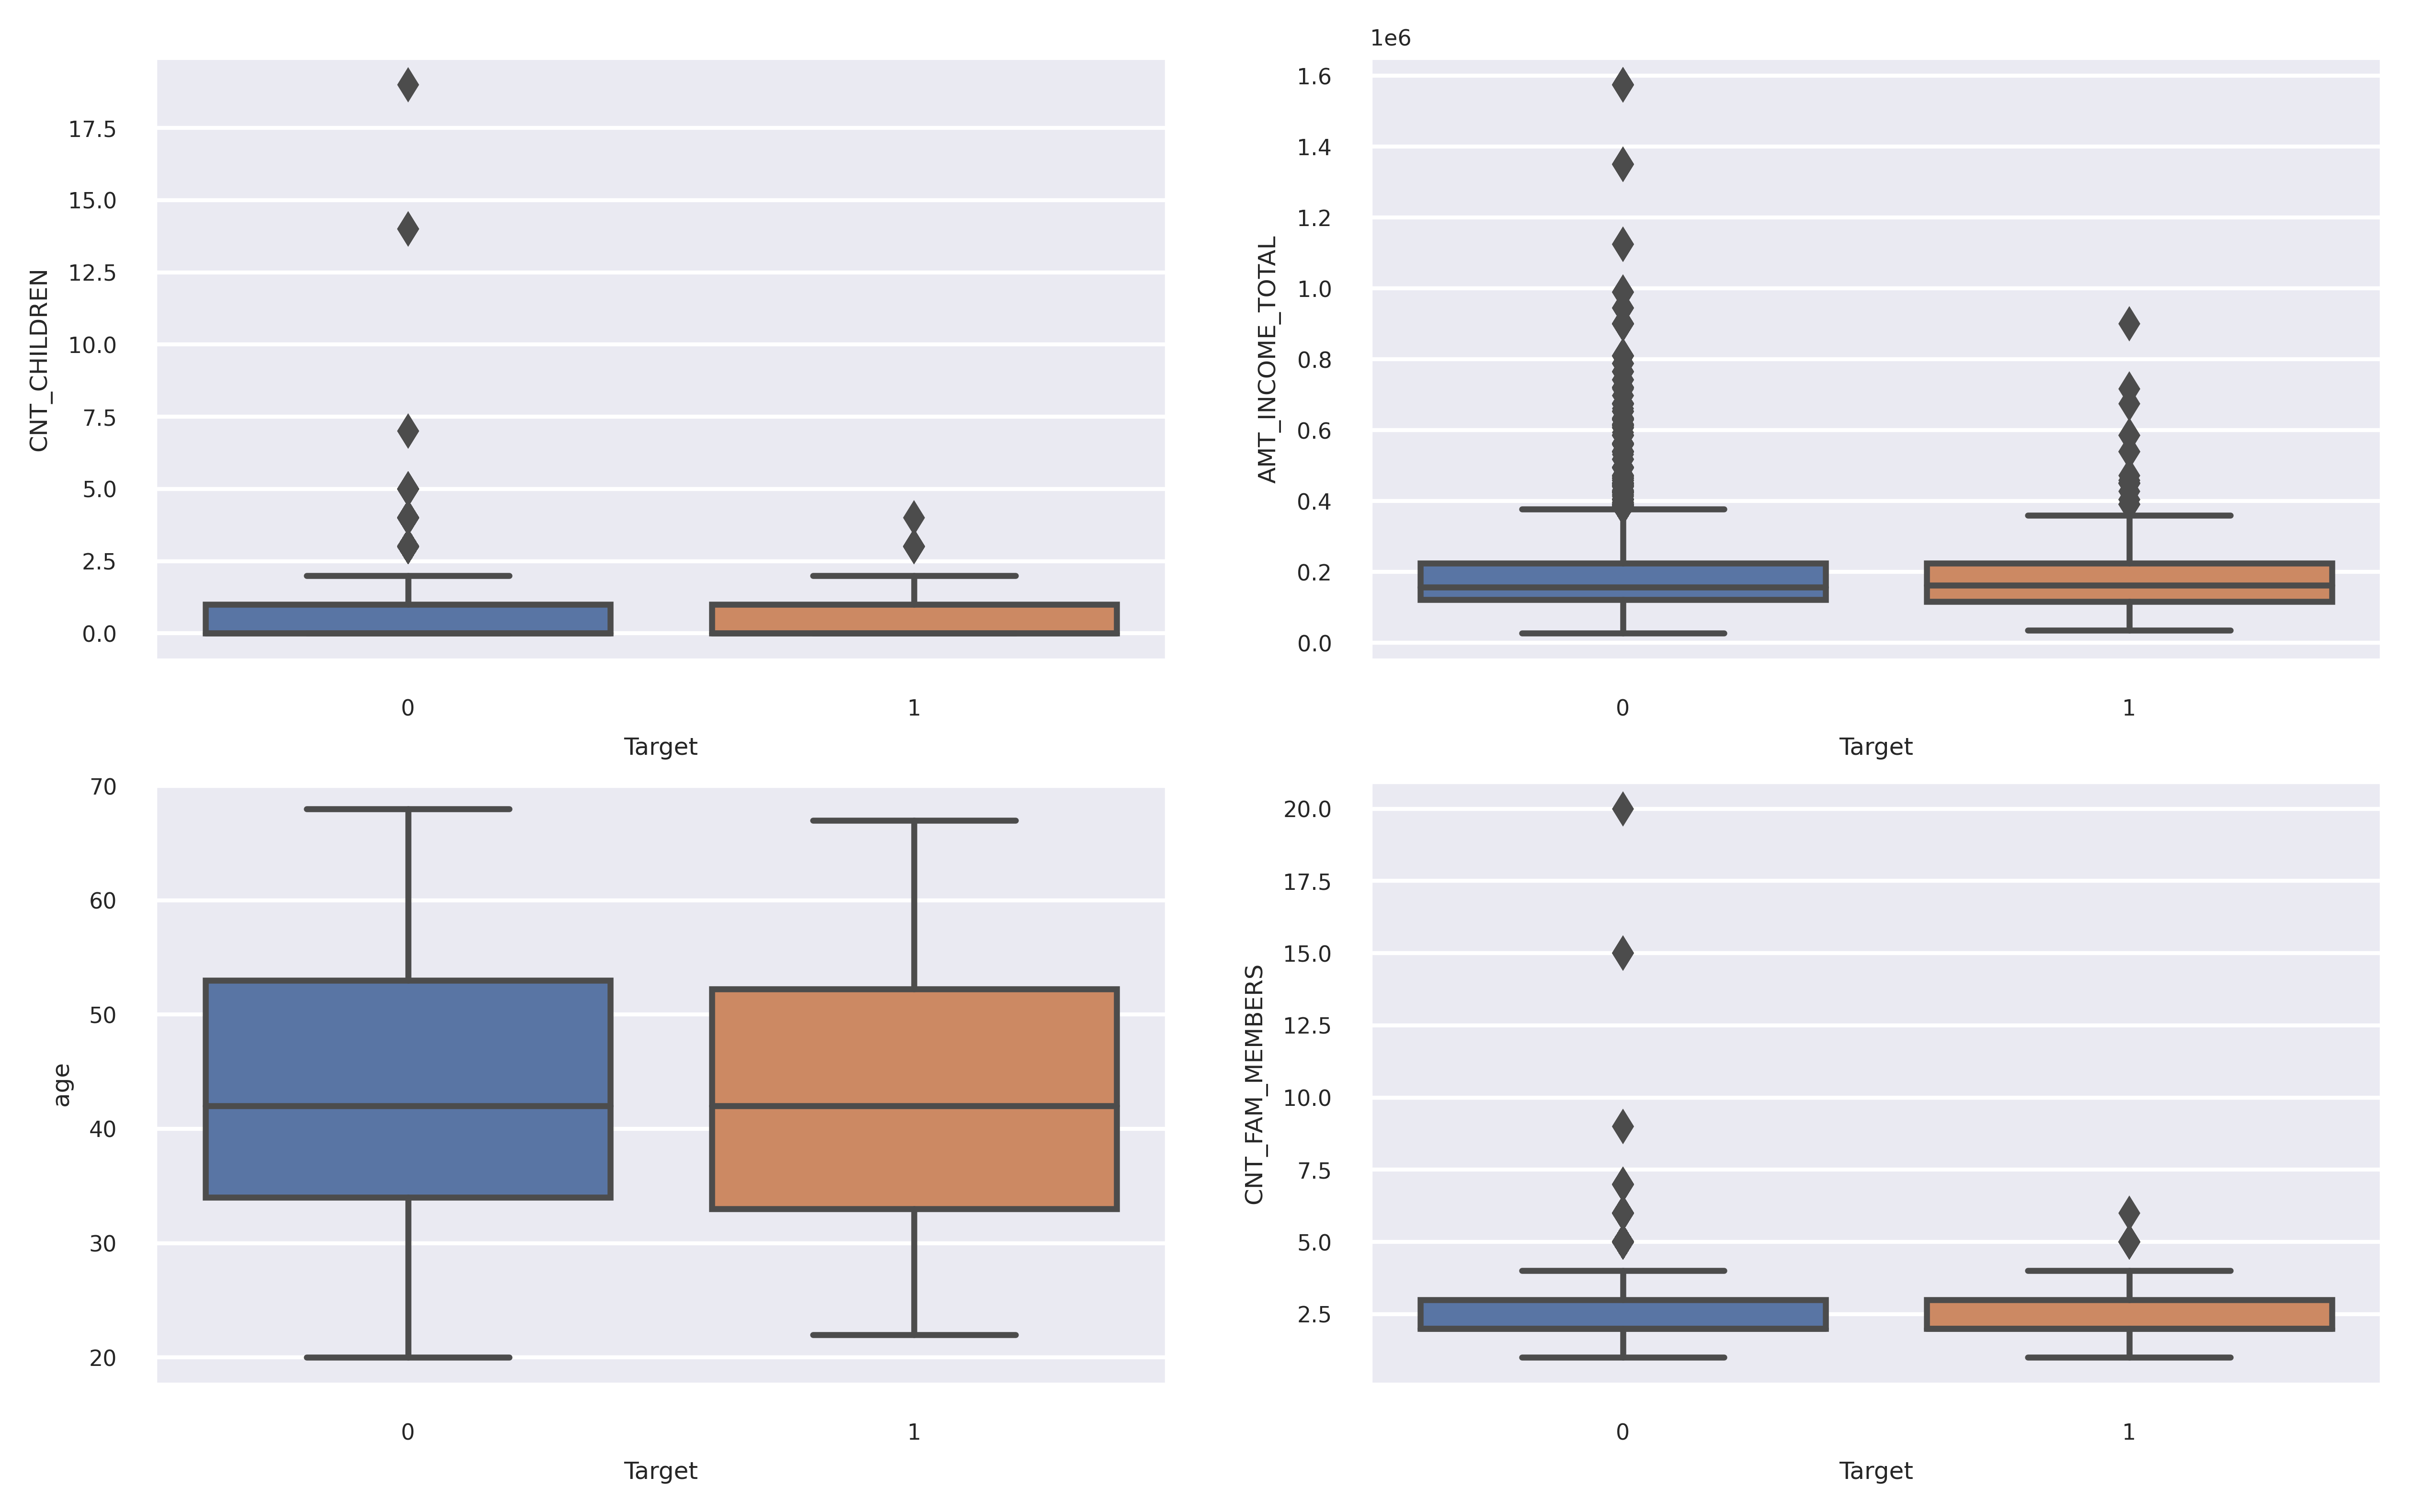

In [85]:
sns.set(rc = {"figure.figsize":(10,6)})
sns.set(font_scale=0.5)
fig, axes = plt.subplots(2, 2)

ax = sns.boxplot(x="Target", y="CNT_CHILDREN", data=newAppRec, orient='v', 
    ax=axes[0, 0])
ax = sns.boxplot(x="Target", y="AMT_INCOME_TOTAL", data=newAppRec, orient='v', 
    ax=axes[0, 1])
ax = sns.boxplot(x="Target", y="age", data=newAppRec, orient='v', 
    ax=axes[1, 0])
ax = sns.boxplot(x="Target", y="CNT_FAM_MEMBERS", data=newAppRec, orient='v', 
    ax=axes[1, 1])

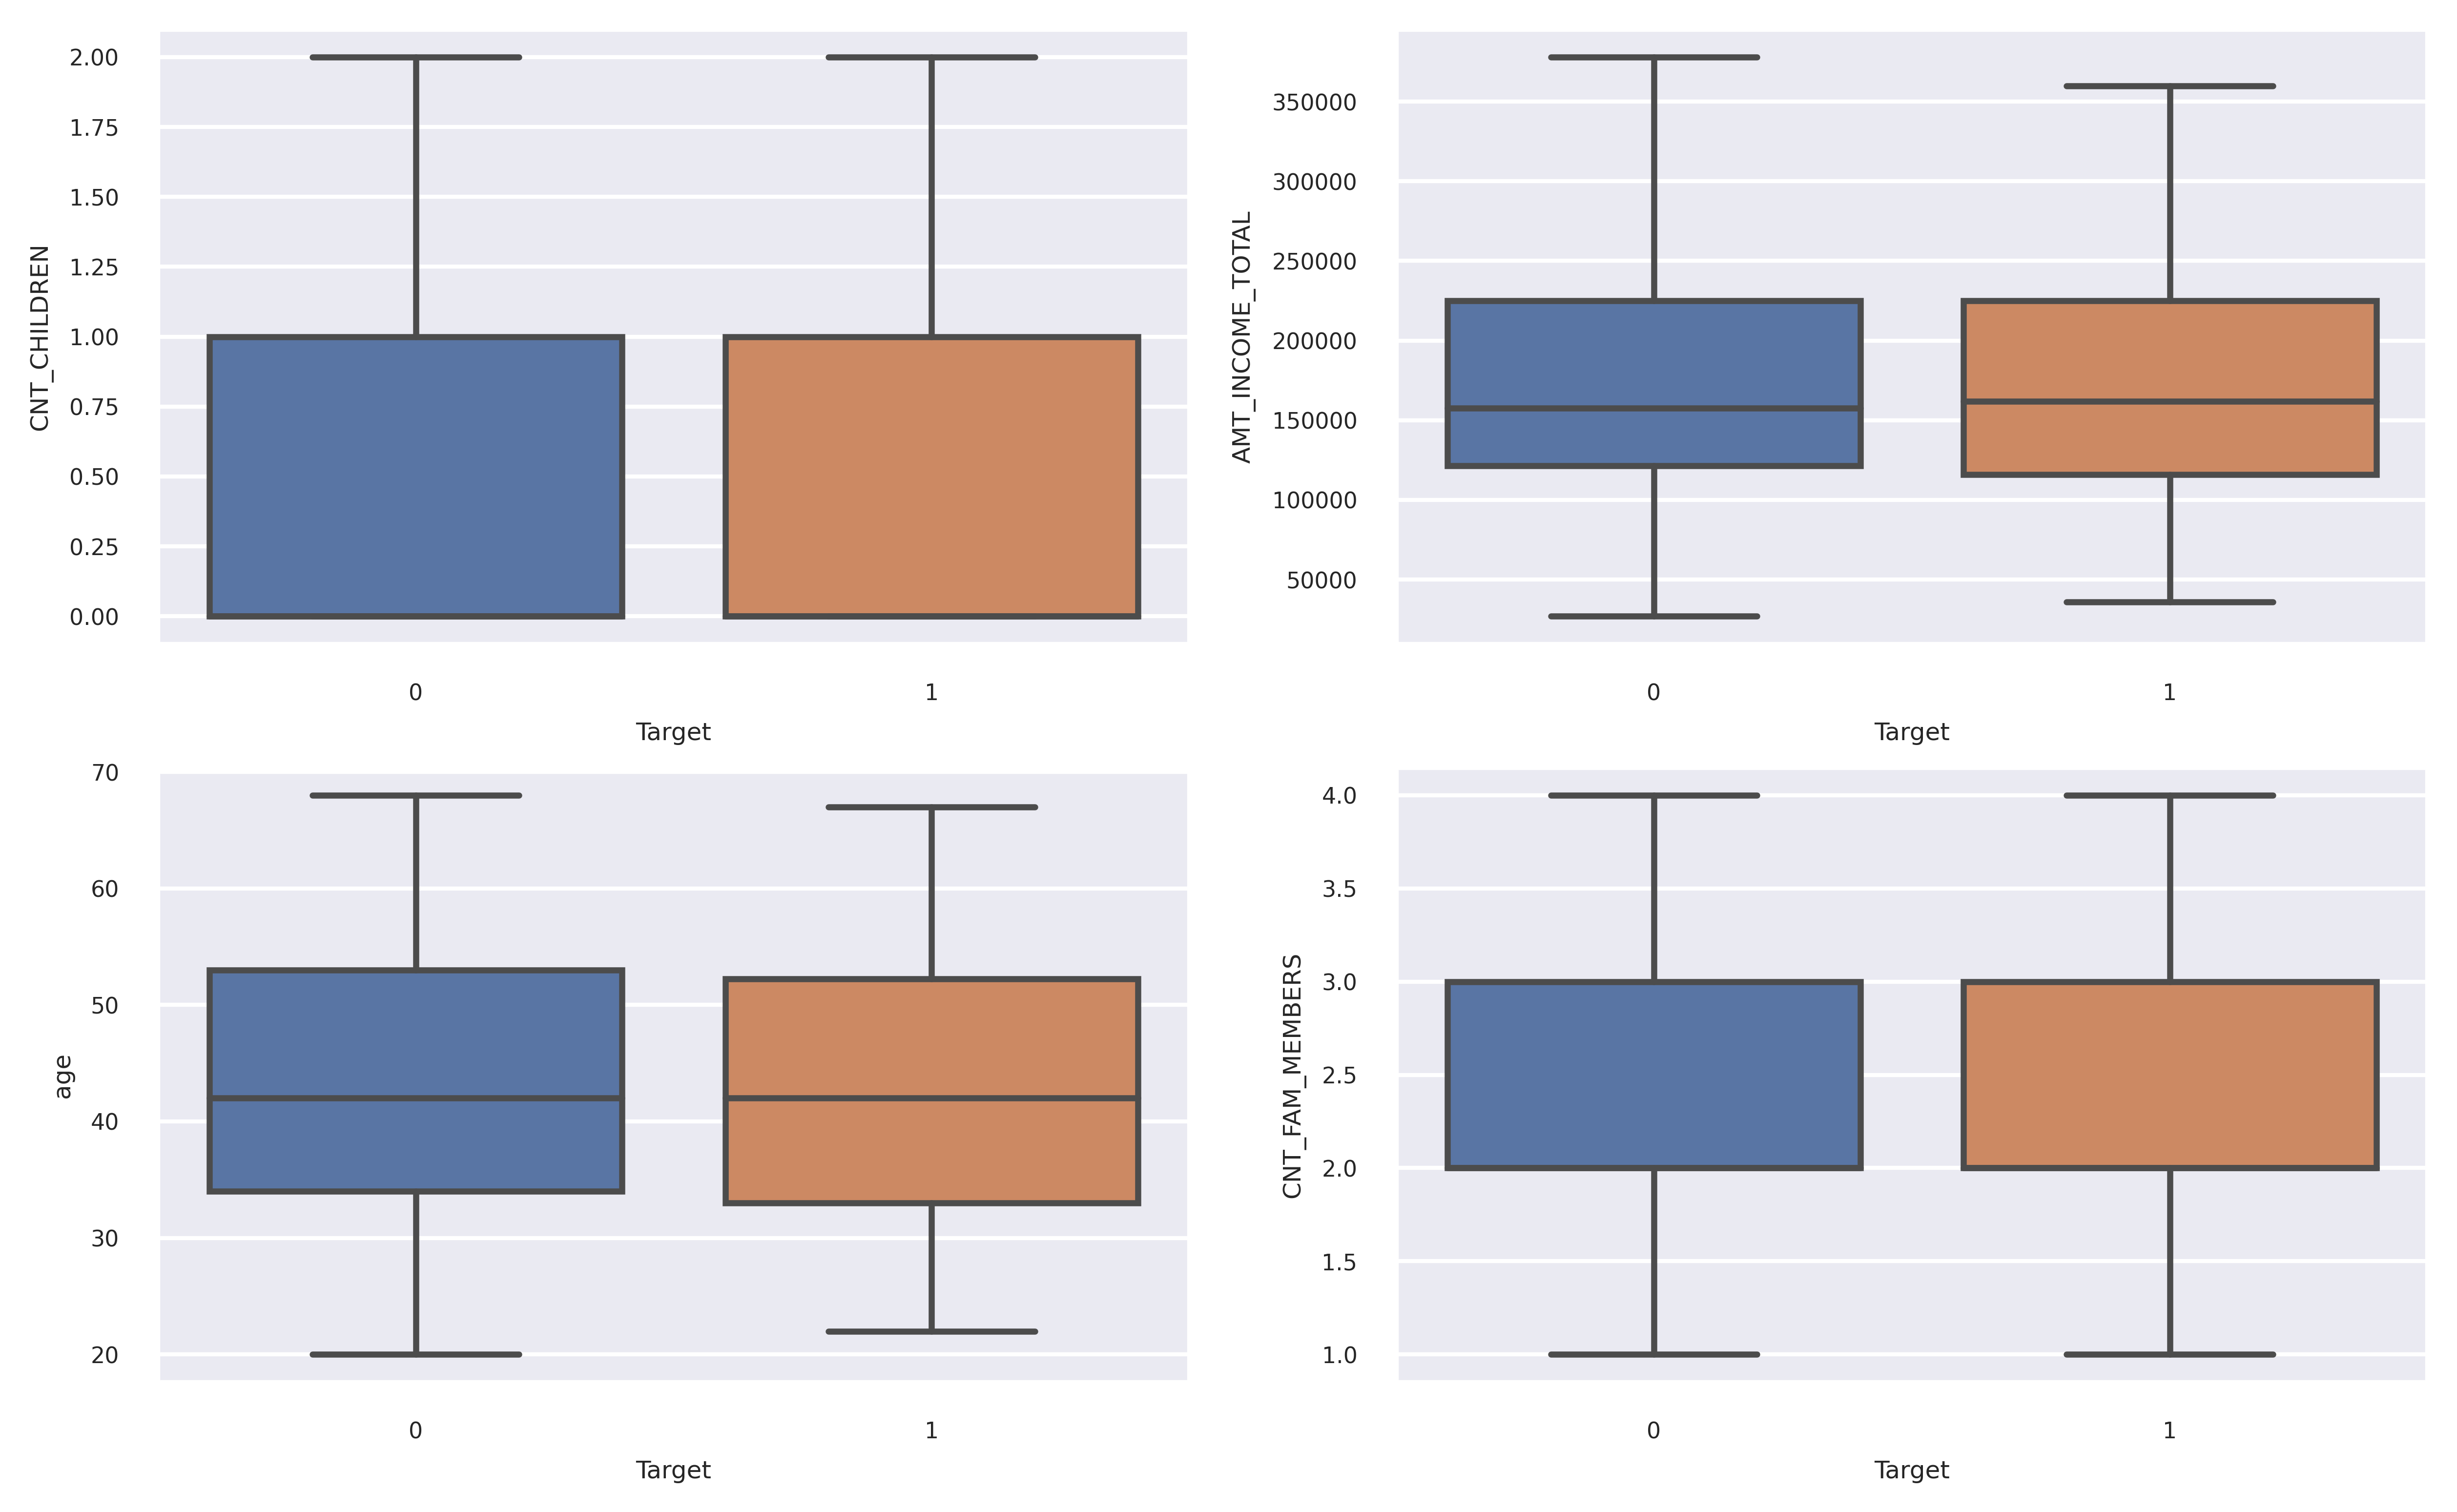

In [86]:

fig, axes = plt.subplots(2, 2)

ax = sns.boxplot(x="Target", y="CNT_CHILDREN", data=newAppRec, orient='v', showfliers = False,
    ax=axes[0, 0])
ax = sns.boxplot(x="Target", y="AMT_INCOME_TOTAL", data=newAppRec, orient='v', showfliers = False,
    ax=axes[0, 1])
ax = sns.boxplot(x="Target", y="age", data=newAppRec, orient='v', 
    ax=axes[1, 0])
ax = sns.boxplot(x="Target", y="CNT_FAM_MEMBERS", data=newAppRec, orient='v', showfliers = False,
    ax=axes[1, 1])

There is a slight difference between **target** 1 and 0 on both **age** and **Annual income**. 

In [88]:
#Let's see about categorical data 
sns.set(rc = {"figure.figsize":(18,16)})
fig, axis = plt.subplots(2, 2)
fig.tight_layout(pad=10.0)


p1= sns.countplot(y='NAME_HOUSING_TYPE',data=newAppRec, ax=axis.flatten()[0])
p1.set_yticklabels(p1.get_yticklabels(), rotation=45)
p1.set_title("Customer Distribution by Housing Type")
p1.set_xlabel("Count")
p1.set_ylabel("Housing Type")

p2= sns.countplot(y='NAME_EDUCATION_TYPE',data=newAppRec, ax=axis.flatten()[1])
p2.set_yticklabels(p2.get_yticklabels(), rotation=45)
p2.set_title("Customer Distribution by Education")
p2.set_xlabel("Count")
p2.set_ylabel("Education Type")


p3=sns.countplot(y='NAME_INCOME_TYPE',data=newAppRec, ax=axis.flatten()[2])
p3.set_yticklabels(p3.get_yticklabels(), rotation=45)
p3.set_title("Customer Distribution by Income Type")
p3.set_xlabel("Count")

p4=sns.countplot(y='NAME_FAMILY_STATUS',data=newAppRec, ax=axis.flatten()[3])
p4.set_yticklabels(p4.get_yticklabels(), rotation=45)
p4.set_title("Customer Distribution by Family Status")
p4.set_xlabel("Count")

Text(0.5, 853.4999999999998, 'Count')

variance for both variables **Housing Type** and Name **Family status** are **low**.
we need to addresses this issue later on 

In [90]:
newAppRec.head()

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   
5008808           F            N               Y             0   
5008809           F            N               Y             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
ID                                                
5008804          427500.0               Working   
5008805          427500.0               Working   
5008806          112500.0               Working   
5008808          270000.0  Commercial associate   
5008809          270000.0  Commercial associate   

                   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
ID                                                             
5008804               Higher education        Civil marriage   
5008805               Higher education        Civil marriage   
5008806  Secondary / secondary special               Married   
5008808  Secondary / secondary special  Single / not married   
5008809  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  \
ID                                                                    
5008804   Rented apartment           1                1           0   
5008805   Rented apartment           1                1           0   
5008806  House / apartment           1                0           0   
5008808  House / apartment           1                0           1   
5008809  House / apartment           1                0           1   

         FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS Target  age  unemployed  \
ID                                                                             
5008804           0   Not mentioned              2.0      0   32           0   
5008805           0   Not mentioned              2.0      0   32           0   
5008806           0  Security staff              2.0      0   58           0   
5008808           1     Sales staff              1.0      0   52           0   
5008809           1     Sales staff              1.0      0   52           0   

         monthEmployed  
ID                      
5008804            151  
5008805            151  
5008806             37  
5008808            101  
5008809            101

In [83]:
#Let's see about categorical data 
sns.set(rc = {"figure.figsize":(18,16)})
fig, axis = plt.subplots(2, 4)



p1 = (newAppRec['CODE_GENDER']
 .groupby(newAppRec['Target'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='CODE_GENDER', y='proportion', hue='Target',ax=axis.flatten()[0]))

p2 = (newAppRec['FLAG_OWN_CAR']
 .groupby(newAppRec['Target'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='FLAG_OWN_CAR', y='proportion', hue='Target',ax=axis.flatten()[1]))

p3 = (newAppRec['FLAG_OWN_REALTY']
 .groupby(newAppRec['Target'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='FLAG_OWN_REALTY', y='proportion', hue='Target',ax=axis.flatten()[2]))



p4 = (newAppRec['FLAG_MOBIL']
 .groupby(newAppRec['Target'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='FLAG_MOBIL', y='proportion', hue='Target',ax=axis.flatten()[3]))

p5 = (newAppRec['FLAG_WORK_PHONE']
 .groupby(newAppRec['Target'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='FLAG_WORK_PHONE', y='proportion', hue='Target',ax=axis.flatten()[4]))


p6 = (newAppRec['FLAG_PHONE']
 .groupby(newAppRec['Target'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='FLAG_PHONE', y='proportion', hue='Target',ax=axis.flatten()[5]))

p7 = (newAppRec['FLAG_EMAIL']
 .groupby(newAppRec['Target'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='FLAG_EMAIL', y='proportion', hue='Target',ax=axis.flatten()[6]))


p8 = (newAppRec['unemployed']
 .groupby(newAppRec['Target'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='unemployed', y='proportion', hue='Target',ax=axis.flatten()[7]))

We see here that **FLAG mobil** and **Flag Email** doesn't introduce any information to our data set espacialy **Flag mobil** it's flat.

In [97]:
newAppRec.head()

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   
5008808           F            N               Y             0   
5008809           F            N               Y             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
ID                                                
5008804          427500.0               Working   
5008805          427500.0               Working   
5008806          112500.0               Working   
5008808          270000.0  Commercial associate   
5008809          270000.0  Commercial associate   

                   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
ID                                                             
5008804               Higher education        Civil marriage   
5008805               Higher education        Civil marriage   
5008806  Secondary / secondary special               Married   
5008808  Secondary / secondary special  Single / not married   
5008809  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  \
ID                                                                    
5008804   Rented apartment           1                1           0   
5008805   Rented apartment           1                1           0   
5008806  House / apartment           1                0           0   
5008808  House / apartment           1                0           1   
5008809  House / apartment           1                0           1   

         FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS Target  age  unemployed  \
ID                                                                             
5008804           0   Not mentioned              2.0      0   32           0   
5008805           0   Not mentioned              2.0      0   32           0   
5008806           0  Security staff              2.0      0   58           0   
5008808           1     Sales staff              1.0      0   52           0   
5008809           1     Sales staff              1.0      0   52           0   

         monthEmployed  
ID                      
5008804            151  
5008805            151  
5008806             37  
5008808            101  
5008809            101

## Preprocessing data

In [95]:
newAppRec.index.nunique() - newAppRec.shape[0]
# make sure no duplicate ID

0

### Catgeorical data:

In [91]:
newAppRec = (newAppRec
           .assign(CODE_GENDER = lambda x:x.CODE_GENDER.replace(['F','M'],[0,1]),
                   FLAG_OWN_CAR = lambda x:x.FLAG_OWN_CAR.replace(["Y","N"],[1,0]),
                   FLAG_OWN_REALTY = lambda x:x.FLAG_OWN_REALTY.replace(["Y","N"],[1,0]),
                   NAME_INCOME_TYPE = lambda x: x.NAME_INCOME_TYPE.replace(['Commercial associate','State servant','Working','Pensioner','Student'],['w','w','w','p','s']),
                   NAME_EDUCATION_TYPE = lambda x:x.NAME_EDUCATION_TYPE.replace(['Secondary / secondary special','Lower secondary','Higher education','Incomplete higher','Academic degree'],['s','s','h','h','a']),
                NAME_FAMILY_STATUS = lambda x:x.NAME_FAMILY_STATUS.replace(['Single / not married','Separated','Widow','Civil marriage','Married'],[0,0,0,1,1]),
                    
                   )
             .drop(columns=['FLAG_MOBIL','NAME_HOUSING_TYPE','FLAG_EMAIL'])
             
              
          )
#we will addresse Occupation type later on

In [92]:
newAppRec.head()

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                                  
5008804            1             1                1             0   
5008805            1             1                1             0   
5008806            1             1                1             0   
5008808            0             0                1             0   
5008809            0             0                1             0   

         AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
ID                                                               
5008804          427500.0                w                   h   
5008805          427500.0                w                   h   
5008806          112500.0                w                   s   
5008808          270000.0                w                   s   
5008809          270000.0                w                   s   

         NAME_FAMILY_STATUS  FLAG_WORK_PHONE  FLAG_PHONE OCCUPATION_TYPE  \
ID                                                                         
5008804                   1                1           0   Not mentioned   
5008805                   1                1           0   Not mentioned   
5008806                   1                0           0  Security staff   
5008808                   0                0           1     Sales staff   
5008809                   0                0           1     Sales staff   

         CNT_FAM_MEMBERS Target  age  unemployed  monthEmployed  
ID                                                               
5008804              2.0      0   32           0            151  
5008805              2.0      0   32           0            151  
5008806              2.0      0   58           0             37  
5008808              1.0      0   52           0            101  
5008809              1.0      0   52           0            101

we notice that there is alot of categorical variable.  
we need to to transforme those variables to something that we can use.  

In [93]:
import category_encoders as ce
newAppRec.Target = newAppRec.Target.astype(int)

In [109]:
cat_columns = [ 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
        'OCCUPATION_TYPE','unemployed']

In [110]:

encoder = ce.WOEEncoder(cols=cat_columns)
encoder.fit(newAppRec[cat_columns],newAppRec.Target)

WOEEncoder(cols=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                 'NAME_FAMILY_STATUS', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
                 'OCCUPATION_TYPE', 'unemployed'])

In [111]:

WOE = encoder.transform(newAppRec[cat_columns])

In [112]:
WOE.describe()

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  NAME_INCOME_TYPE  \
count  36457.000000  36457.000000     36457.000000      36457.000000   
mean      -0.006569     -0.000524        -0.013574         -0.005107   
std        0.115186      0.033060         0.164802          0.110634   
min       -0.087387     -0.042779        -0.128660         -0.053886   
25%       -0.087387     -0.042779        -0.128660         -0.053886   
50%       -0.087387      0.025342        -0.128660         -0.053886   
75%        0.157594      0.025342         0.222415         -0.053886   
max        0.157594      0.025342         0.222415          1.575508   

       NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  FLAG_WORK_PHONE    FLAG_PHONE  \
count         36457.000000        36457.000000     36457.000000  36457.000000   
mean              0.000264           -0.007940        -0.000975     -0.000090   
std               0.050728            0.125139         0.044461      0.013607   
min              -0.032314           -0.076749        -0.024967     -0.008889   
25%              -0.032314           -0.076749        -0.024967     -0.008889   
50%              -0.032314           -0.076749        -0.024967     -0.008889   
75%               0.071341           -0.076749        -0.024967      0.020955   
max               0.563908            0.219635         0.081415      0.020955   

       OCCUPATION_TYPE    unemployed  
count     36457.000000  36457.000000  
mean         -0.000364     -0.000891  
std           0.232293      0.042356  
min          -0.678703     -0.019943  
25%          -0.063353     -0.019943  
50%           0.016015     -0.019943  
75%           0.132683     -0.019943  
max           1.386266      0.093273

In [113]:
encoder = ce.TargetEncoder(cols=cat_columns)
encoder.fit(newAppRec[cat_columns],newAppRec.Target)
TargetEncoded = encoder.transform(newAppRec[cat_columns])

/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [114]:
TargetEncoded.describe()

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  NAME_INCOME_TYPE  \
count  36457.000000  36457.000000     36457.000000      3.645700e+04   
mean       0.016897      0.016897         0.016897      1.689662e-02   
std        0.001971      0.000560         0.002867      1.928249e-03   
min        0.015514      0.016181         0.014894      7.670704e-07   
25%        0.015514      0.016181         0.014894      1.604278e-02   
50%        0.015514      0.017334         0.014894      1.604278e-02   
75%        0.019706      0.017334         0.021002      1.604278e-02   
max        0.019706      0.017334         0.021002      2.113134e-02   

       NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  FLAG_WORK_PHONE    FLAG_PHONE  \
count         3.645700e+04        36457.000000     36457.000000  36457.000000   
mean          1.689662e-02            0.016897         0.016897      0.016897   
std           9.369612e-04            0.002208         0.000727      0.000204   
min           5.815294e-16            0.015682         0.016504      0.016765   
25%           1.638106e-02            0.015682         0.016504      0.016765   
50%           1.638106e-02            0.015682         0.016504      0.016765   
75%           1.809473e-02            0.015682         0.016504      0.017213   
max           1.809473e-02            0.020912         0.018244      0.017213   

       OCCUPATION_TYPE    unemployed  
count     36457.000000  36457.000000  
mean          0.016897      0.016897  
std           0.004251      0.000685  
min           0.000000      0.016589  
25%           0.015604      0.016589  
50%           0.017133      0.016589  
75%           0.018533      0.016589  
max           0.050000      0.018419

In [116]:

encoder = ce.HashingEncoder(cols=cat_columns)
encoder.fit(newAppRec[cat_columns],newAppRec.Target)

HashingEncoder(cols=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                     'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                     'NAME_FAMILY_STATUS', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
                     'OCCUPATION_TYPE', 'unemployed'],
               max_process=4, max_sample=9114)

In [117]:

Hashencoded = encoder.transform(newAppRec[cat_columns])

In [118]:
Hashencoded

col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7
ID                                                             
5008804      1      1      3      5      0      0      0      0
5008805      1      1      3      5      0      0      0      0
5008806      1      0      3      4      1      1      0      0
5008808      1      0      5      3      1      0      0      0
5008809      1      0      5      3      1      0      0      0
...        ...    ...    ...    ...    ...    ...    ...    ...
5149828      1      1      3      4      1      0      0      0
5149834      1      1      4      3      0      0      0      1
5149838      0      1      5      3      0      0      0      1
5150049      1      0      5      3      1      0      0      0
5150337      1      0      5      2      1      1      0      0

[36457 rows x 8 columns]

In [162]:
trainingDataset = ((newAppRec
                   .drop(columns=['OCCUPATION_TYPE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE'])
                   .merge(WOE,left_index=True, right_index=True))
                   .merge(TargetEncoded,left_index=True, right_index=True)
                   .merge(Hashencoded,left_index=True, right_index=True))

In [163]:
trainingDataset

CODE_GENDER_x  FLAG_OWN_CAR_x  FLAG_OWN_REALTY_x  CNT_CHILDREN  \
ID                                                                        
5008804              1               1                  1             0   
5008805              1               1                  1             0   
5008806              1               1                  1             0   
5008808              0               0                  1             0   
5008809              0               0                  1             0   
...                ...             ...                ...           ...   
5149828              1               1                  1             0   
5149834              0               0                  1             0   
5149838              0               0                  1             0   
5150049              0               0                  1             0   
5150337              1               0                  1             0   

         AMT_INCOME_TOTAL  NAME_FAMILY_STATUS_x  FLAG_WORK_PHONE_x  \
ID                                                                   
5008804          427500.0                     1                  1   
5008805          427500.0                     1                  1   
5008806          112500.0                     1                  0   
5008808          270000.0                     0                  0   
5008809          270000.0                     0                  0   
...                   ...                   ...                ...   
5149828          315000.0                     1                  0   
5149834          157500.0                     1                  0   
5149838          157500.0                     1                  0   
5150049          283500.0                     1                  0   
5150337          112500.0                     0                  0   

         FLAG_PHONE_x  CNT_FAM_MEMBERS  Target  ...  OCCUPATION_TYPE_y  \
ID                                              ...                      
5008804             0              2.0       0  ...           0.017133   
5008805             0              2.0       0  ...           0.017133   
5008806             0              2.0       0  ...           0.021959   
5008808             1              1.0       0  ...           0.012912   
5008809             1              1.0       0  ...           0.012912   
...               ...              ...     ...  ...                ...   
5149828             0              2.0       1  ...           0.015604   
5149834             1              2.0       1  ...           0.008285   
5149838             1              2.0       1  ...           0.008285   
5150049             0              2.0       1  ...           0.012912   
5150337             0              1.0       1  ...           0.015939   

         unemployed  col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  
ID                                                                           
5008804    0.016589      1      1      3      5      0      0      0      0  
5008805    0.016589      1      1      3      5      0      0      0      0  
5008806    0.016589      1      0      3      4      1      1      0      0  
5008808    0.016589      1      0      5      3      1      0      0      0  
5008809    0.016589      1      0      5      3      1      0      0      0  
...             ...    ...    ...    ...    ...    ...    ...    ...    ...  
5149828    0.016589      1      1      3      4      1      0      0      0  
5149834    0.016589      1      1      4      3      0      0      0      1  
5149838    0.016589      0      1      5      3      0      0      0      1  
5150049    0.016589      1      0      5      3      1      0      0      0  
5150337    0.016589      1      0      5      2      1      1      0      0  

[36457 rows x 41 columns]

In [106]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
newAppRec.Target = newAppRec.Target.astype(int)

In [271]:
X_col = list(set(trainingDataset.columns) - set(['Target']))

In [272]:
scaler = MinMaxScaler()
X = (scaler.fit_transform(trainingDataset[X_col]))
pca = PCA(n_components=2,whiten=True,svd_solver='arpack')
X_r = pca.fit(X).transform(X)

In [273]:

pc_df = pd.DataFrame(data = X_r , 
        columns = ['PC1', 'PC2'])
pc_df['Cluster'] = trainingDataset.Target.values

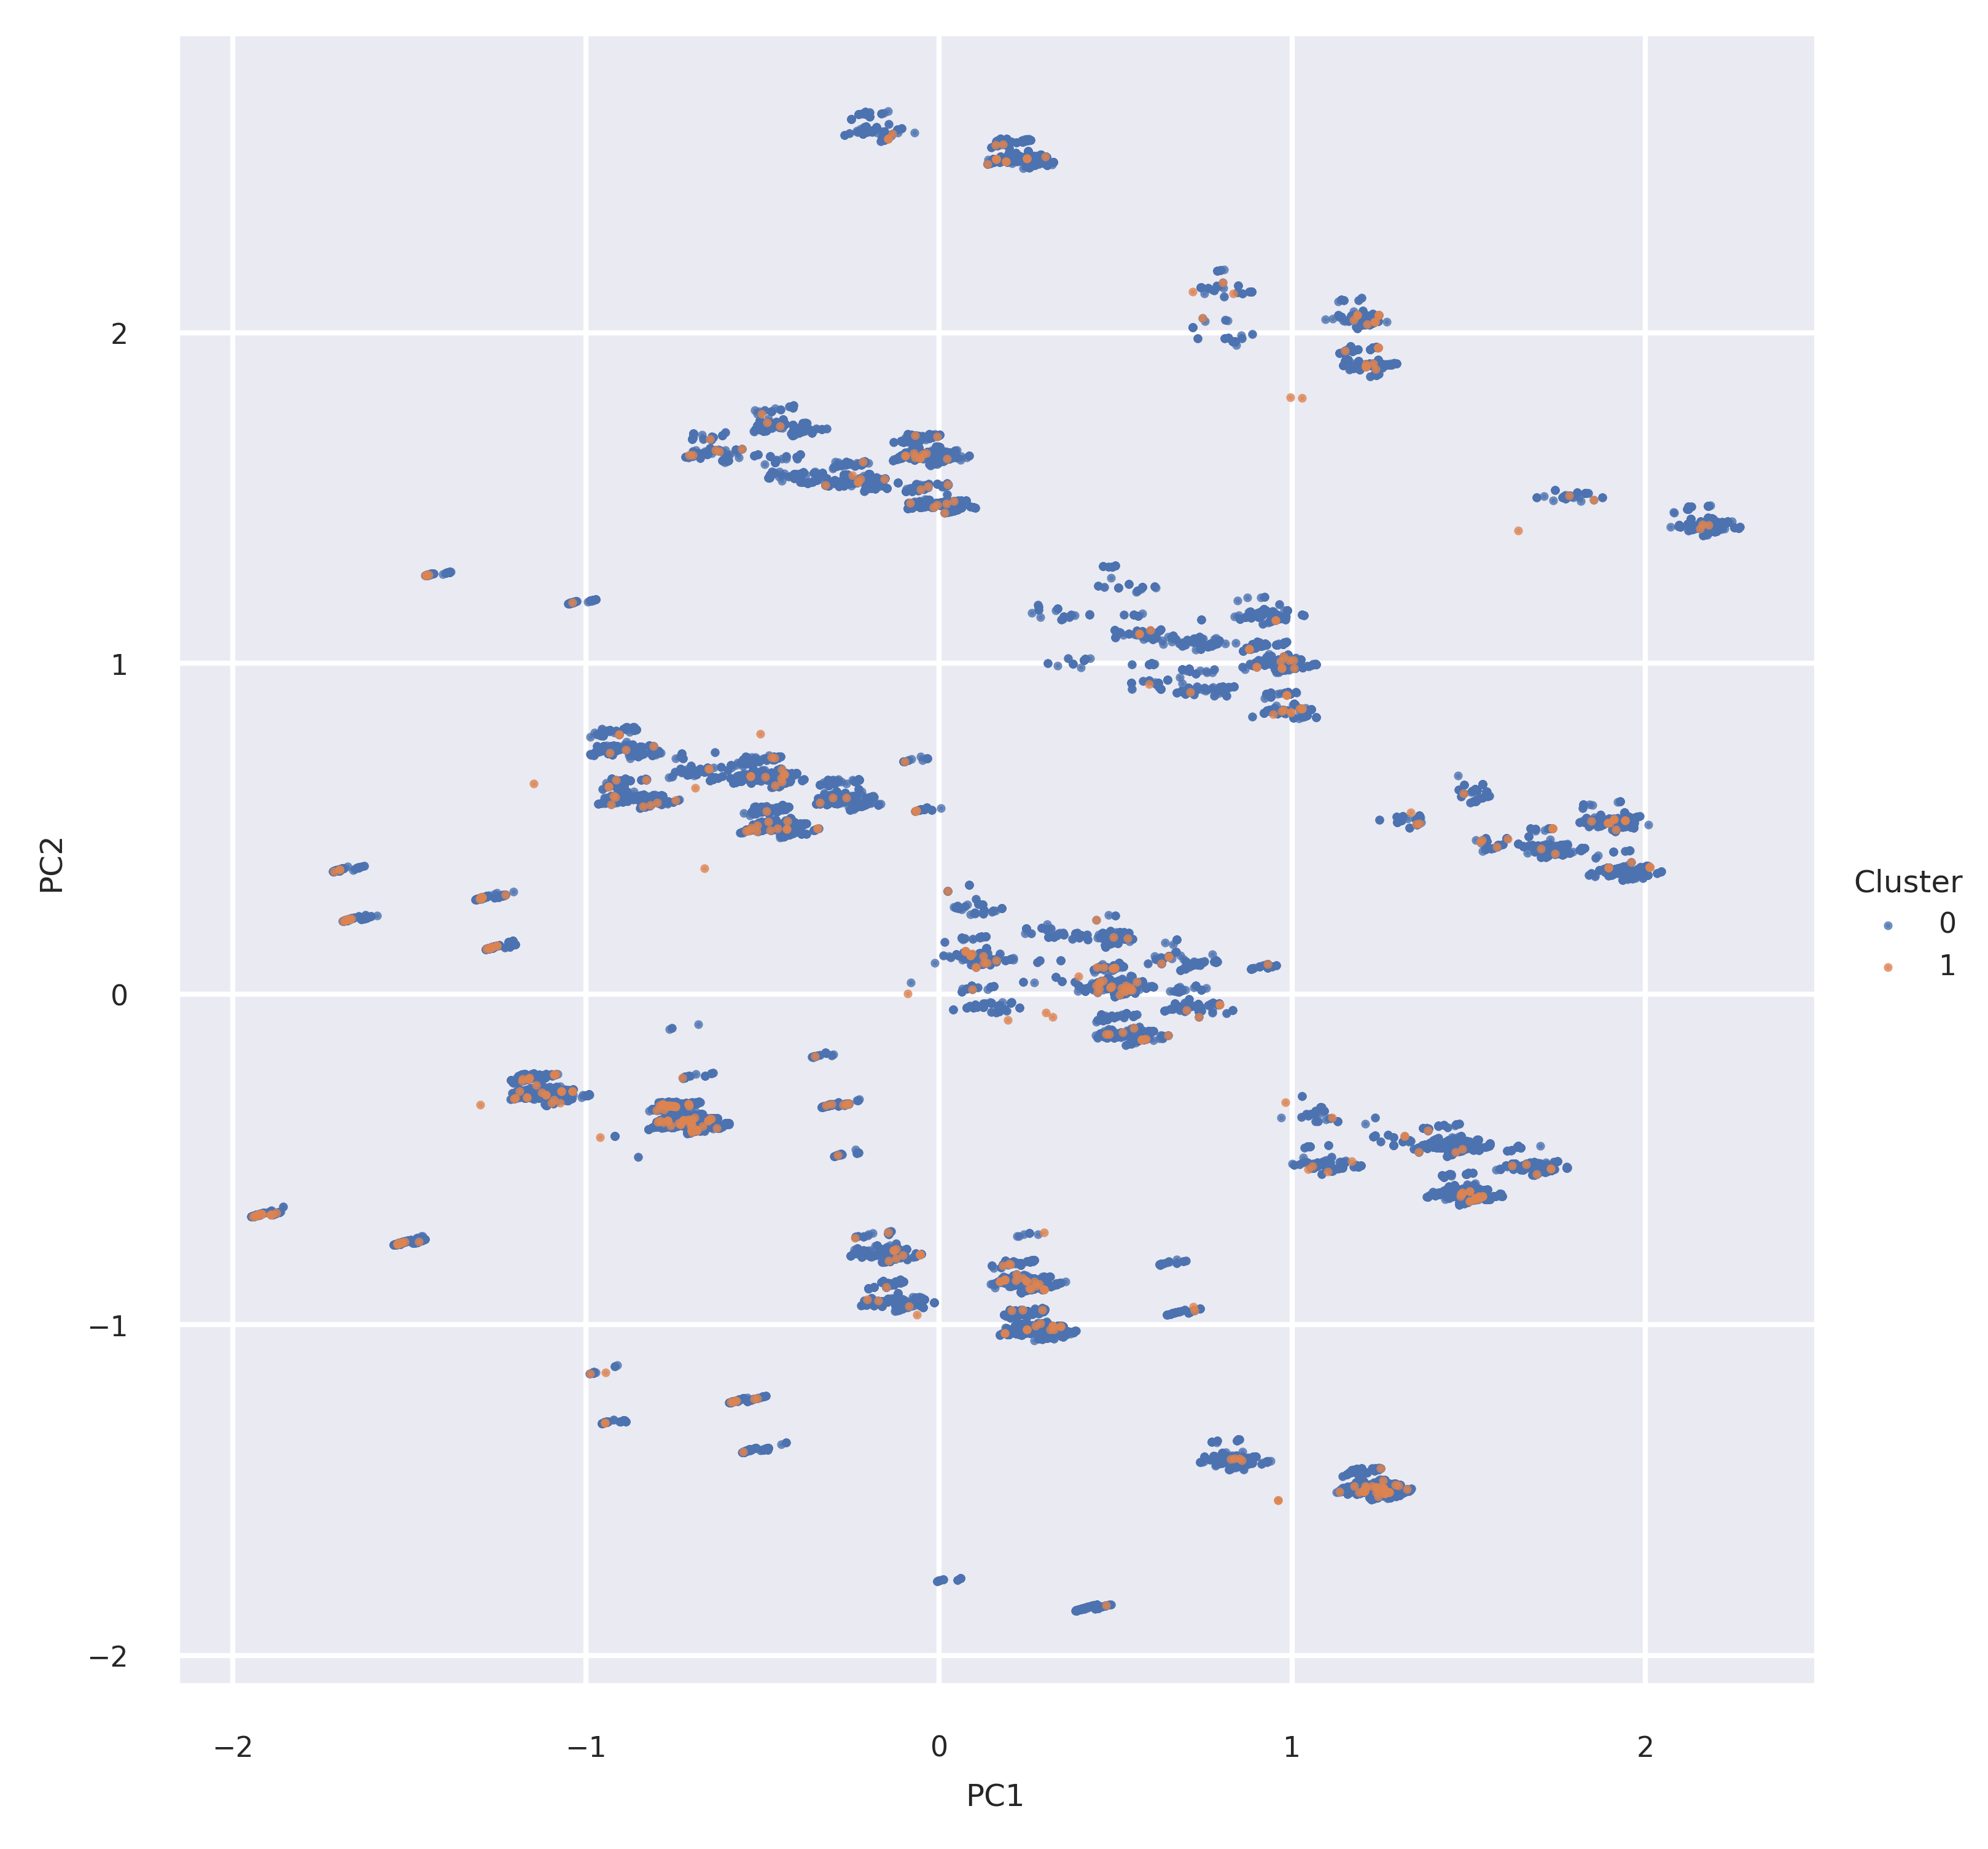

In [274]:

sns.set(rc = {"figure.figsize":(10,6)})
sns.set(font_scale=0.5)

sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 0.5}) # specify the point size

We notice that some of clusters contain lower ratio of 1 and 0 classes.  
But still most of onservation **target==1**  aren't distinct from **Target == 0**.

In [276]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=150,early_exaggeration=200).fit_transform(X)

In [277]:

pc_df = pd.DataFrame(data = X_embedded , 
        columns = ['x', 'y'])
pc_df['Cluster'] = trainingDataset.Target.values

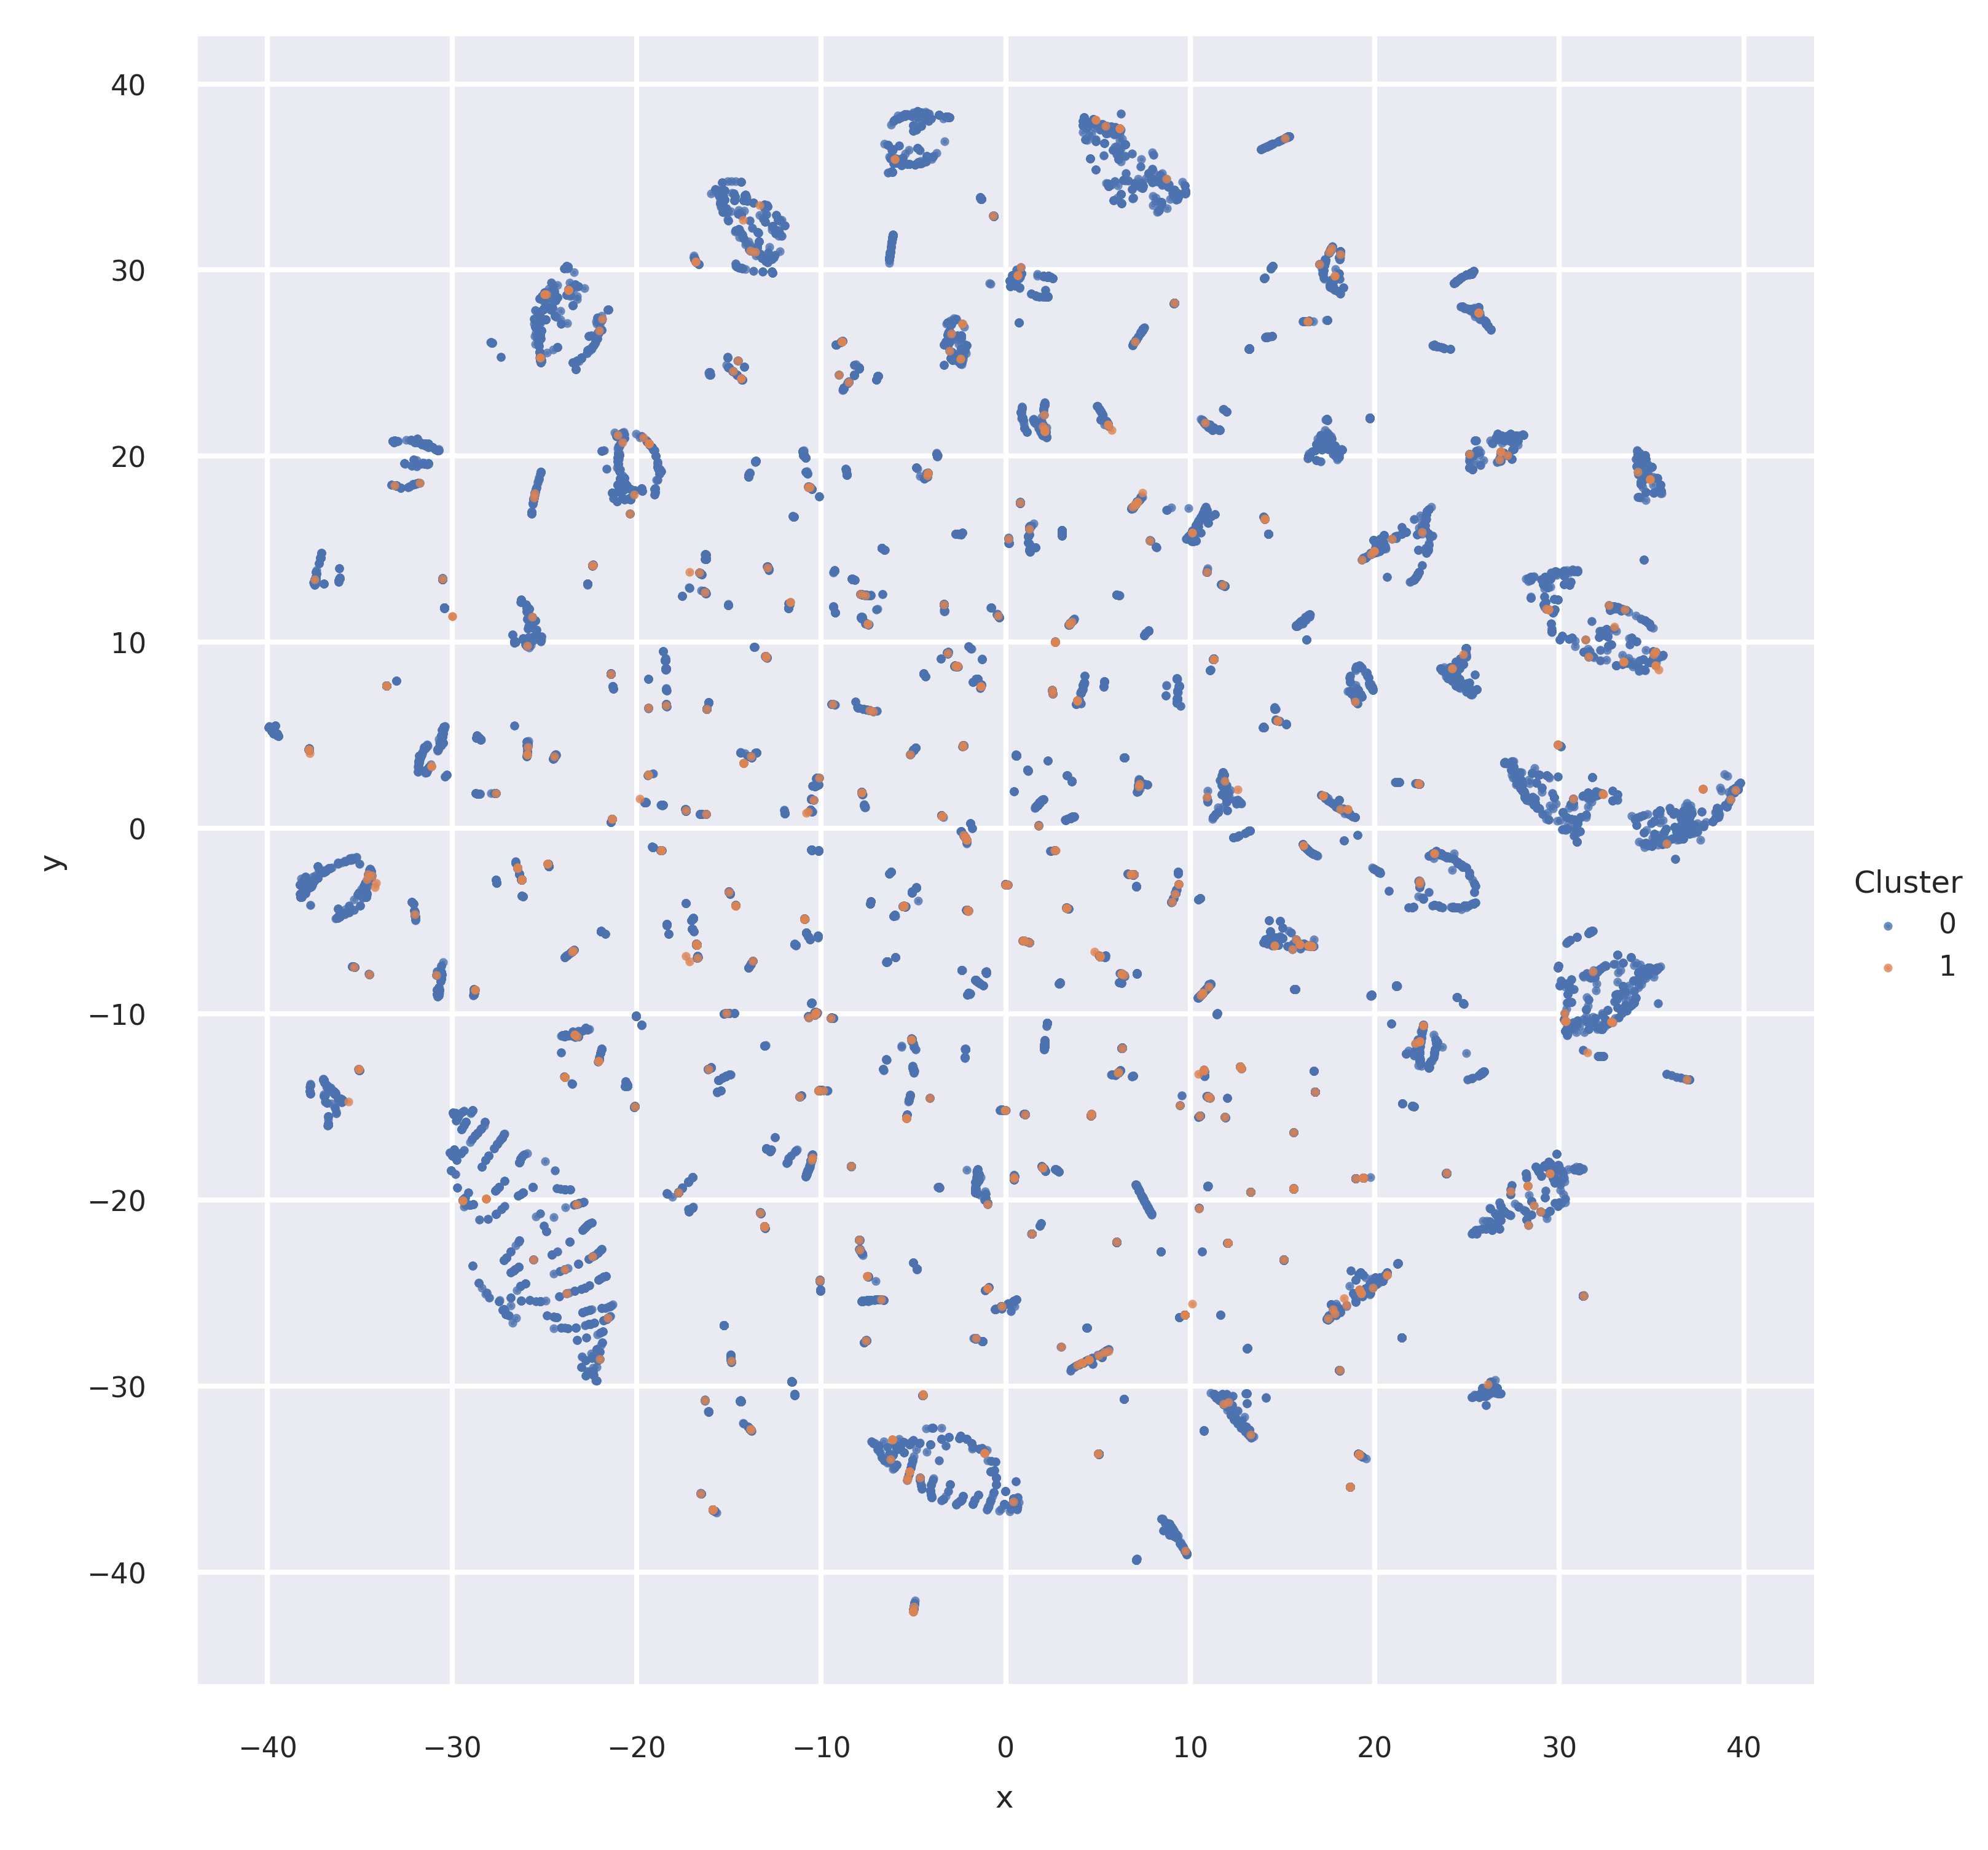

In [278]:

sns.set(rc = {"figure.figsize":(10,6)})
sns.set(font_scale=0.5)

sns.lmplot( x="x", y="y",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 0.5}) # specify the point size

With TSNE we can see that even if the **target ==1** is all over the place, and the majority of **Target ==1** is on top  of **target == 0** which worry me, I only see that when data is augmented syntheticly using over sampline algorithms like **RandomOverSampler** from **imbalanced-learn** (as an example)

In [280]:
from sklearn.model_selection import train_test_split

#splitting data into train-test

X_train, X_test, y_train, y_test = train_test_split(trainingDataset[X_col],
                                                    trainingDataset.Target.values,
                                                    random_state=1,
                                                    test_size=0.25)
scaler = MinMaxScaler()
X_trainT = scaler.fit_transform(X_train)
X_testT = scaler.transform(X_test)

In [281]:
# The data is heavely unblanaced, so we need to apply different method to balance.
#Data Balancing
from imblearn.over_sampling import SVMSMOTE
from imblearn.combine import SMOTETomek

In [282]:
oversampler = SVMSMOTE()
undersampler = SMOTETomek()

In [283]:
X_overResampled, y_overResampled = oversampler.fit_resample(X_trainT,y_train )
X_underResampled, y_underResampled = undersampler.fit_resample(X_trainT,y_train )

In [298]:
from tpot import TPOTClassifier


tpot = TPOTClassifier(verbosity=2,scoring='f1',  max_time_mins=100)
tpot.fit(X_train, y_train)


                                                                                
Generation 1 - Current best internal CV score: 0.26943662777396477
                                                                                
Generation 2 - Current best internal CV score: 0.28495342010019464
                                                                                
Generation 3 - Current best internal CV score: 0.28495342010019464
                                                                                
100.90 minutes have elapsed. TPOT will close down.                              
TPOT closed during evaluation in one generation.
                                                                                
                                                                                
TPOT closed prematurely. Will use the current best pipeline.
                                                                                
Best pipeline: ExtraTreesClassifier(Selec

TPOTClassifier(max_time_mins=100, scoring='f1', verbosity=2)

In [300]:
tpot.score(X_test, y_test)

/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:765: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(
/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.26771653543307083

In [299]:
tpot.export('tpot_CreditScorePipeline.py')

In [301]:
y_pred = tpot.predict(X_test)

/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [304]:
confusion_matrix(y_test,y_pred)


array([[8895,   55],
       [ 131,   34]])

In [305]:
## Very bad output, model can't make distinction using data we have

y_pred_prob = tpot.predict_proba(X_test)

/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [327]:
def create_pred(y, prob):
    # Function to modify the Threshold
    return [i[0]<= prob for i in y]

In [328]:
confusion_matrix(y_test,create_pred(y_pred_prob,0.90))

array([[8694,  256],
       [  96,   69]])

**The model is not calibrated and under preforming. **

## Iteration 2

In [329]:
newAppRec

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                                  
5008804            1             1                1             0   
5008805            1             1                1             0   
5008806            1             1                1             0   
5008808            0             0                1             0   
5008809            0             0                1             0   
...              ...           ...              ...           ...   
5149828            1             1                1             0   
5149834            0             0                1             0   
5149838            0             0                1             0   
5150049            0             0                1             0   
5150337            1             0                1             0   

         AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
ID                                                               
5008804          427500.0                w                   h   
5008805          427500.0                w                   h   
5008806          112500.0                w                   s   
5008808          270000.0                w                   s   
5008809          270000.0                w                   s   
...                   ...              ...                 ...   
5149828          315000.0                w                   s   
5149834          157500.0                w                   h   
5149838          157500.0                p                   h   
5150049          283500.0                w                   s   
5150337          112500.0                w                   s   

         NAME_FAMILY_STATUS  FLAG_WORK_PHONE  FLAG_PHONE OCCUPATION_TYPE  \
ID                                                                         
5008804                   1                1           0   Not mentioned   
5008805                   1                1           0   Not mentioned   
5008806                   1                0           0  Security staff   
5008808                   0                0           1     Sales staff   
5008809                   0                0           1     Sales staff   
...                     ...              ...         ...             ...   
5149828                   1                0           0        Managers   
5149834                   1                0           1  Medicine staff   
5149838                   1                0           1  Medicine staff   
5150049                   1                0           0     Sales staff   
5150337                   0                0           0        Laborers   

         CNT_FAM_MEMBERS  Target  age  unemployed  monthEmployed  
ID                                                                
5008804              2.0       0   32           0            151  
5008805              2.0       0   32           0            151  
5008806              2.0       0   58           0             37  
5008808              1.0       0   52           0            101  
5008809              1.0       0   52           0            101  
...                  ...     ...  ...         ...            ...  
5149828              2.0       1   47           0             80  
5149834              2.0       1   33           0             44  
5149838              2.0       1   33           0             44  
5150049              2.0       1   49           0             21  
5150337              1.0       1   25           0             39  

[36457 rows x 16 columns]

I don't understand how is that possible that there is people **unemployed** with **AMT_INCOME_TOTAL** doesn't make any sense.

In [334]:
newAppRec[newAppRec.unemployed==1]

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                                  
5008812            0             0                1             0   
5008813            0             0                1             0   
5008814            0             0                1             0   
5008884            0             0                1             0   
5008974            0             0                1             0   
...              ...           ...              ...           ...   
5126278            0             0                0             0   
5139446            0             0                1             0   
5145690            0             0                1             0   
5145817            0             0                1             0   
5148602            1             0                1             0   

         AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
ID                                                               
5008812          283500.0                p                   h   
5008813          283500.0                p                   h   
5008814          283500.0                p                   h   
5008884          315000.0                p                   s   
5008974          112500.0                p                   s   
...                   ...              ...                 ...   
5126278          162000.0                p                   s   
5139446          112500.0                p                   s   
5145690          306000.0                p                   h   
5145817           90000.0                p                   s   
5148602          225000.0                p                   s   

         NAME_FAMILY_STATUS  FLAG_WORK_PHONE  FLAG_PHONE OCCUPATION_TYPE  \
ID                                                                         
5008812                   0                0           0   Not mentioned   
5008813                   0                0           0   Not mentioned   
5008814                   0                0           0   Not mentioned   
5008884                   0                0           0   Not mentioned   
5008974                   1                0           0   Not mentioned   
...                     ...              ...         ...             ...   
5126278                   1                0           0   Not mentioned   
5139446                   0                0           1   Not mentioned   
5145690                   1                0           0   Not mentioned   
5145817                   1                0           0   Not mentioned   
5148602                   1                0           0   Not mentioned   

         CNT_FAM_MEMBERS  Target  age  unemployed  monthEmployed  
ID                                                                
5008812              1.0       0   61           1              0  
5008813              1.0       0   61           1              0  
5008814              1.0       0   61           1              0  
5008884              1.0       0   55           1              0  
5008974              2.0       0   61           1              0  
...                  ...     ...  ...         ...            ...  
5126278              2.0       1   58           1              0  
5139446              1.0       1   58           1              0  
5145690              2.0       1   59           1              0  
5145817              2.0       1   60           1              0  
5148602              2.0       1   62           1              0  

[6135 rows x 16 columns]

In [337]:
newAppRec[newAppRec.unemployed==1].OCCUPATION_TYPE.value_counts()


Not mentioned    6135
Name: OCCUPATION_TYPE, dtype: int64

All their occupation was **NA**. But their age is **old**.  
Let's plot box plot of their **age**.

Text(0.5, 0, 'Age')

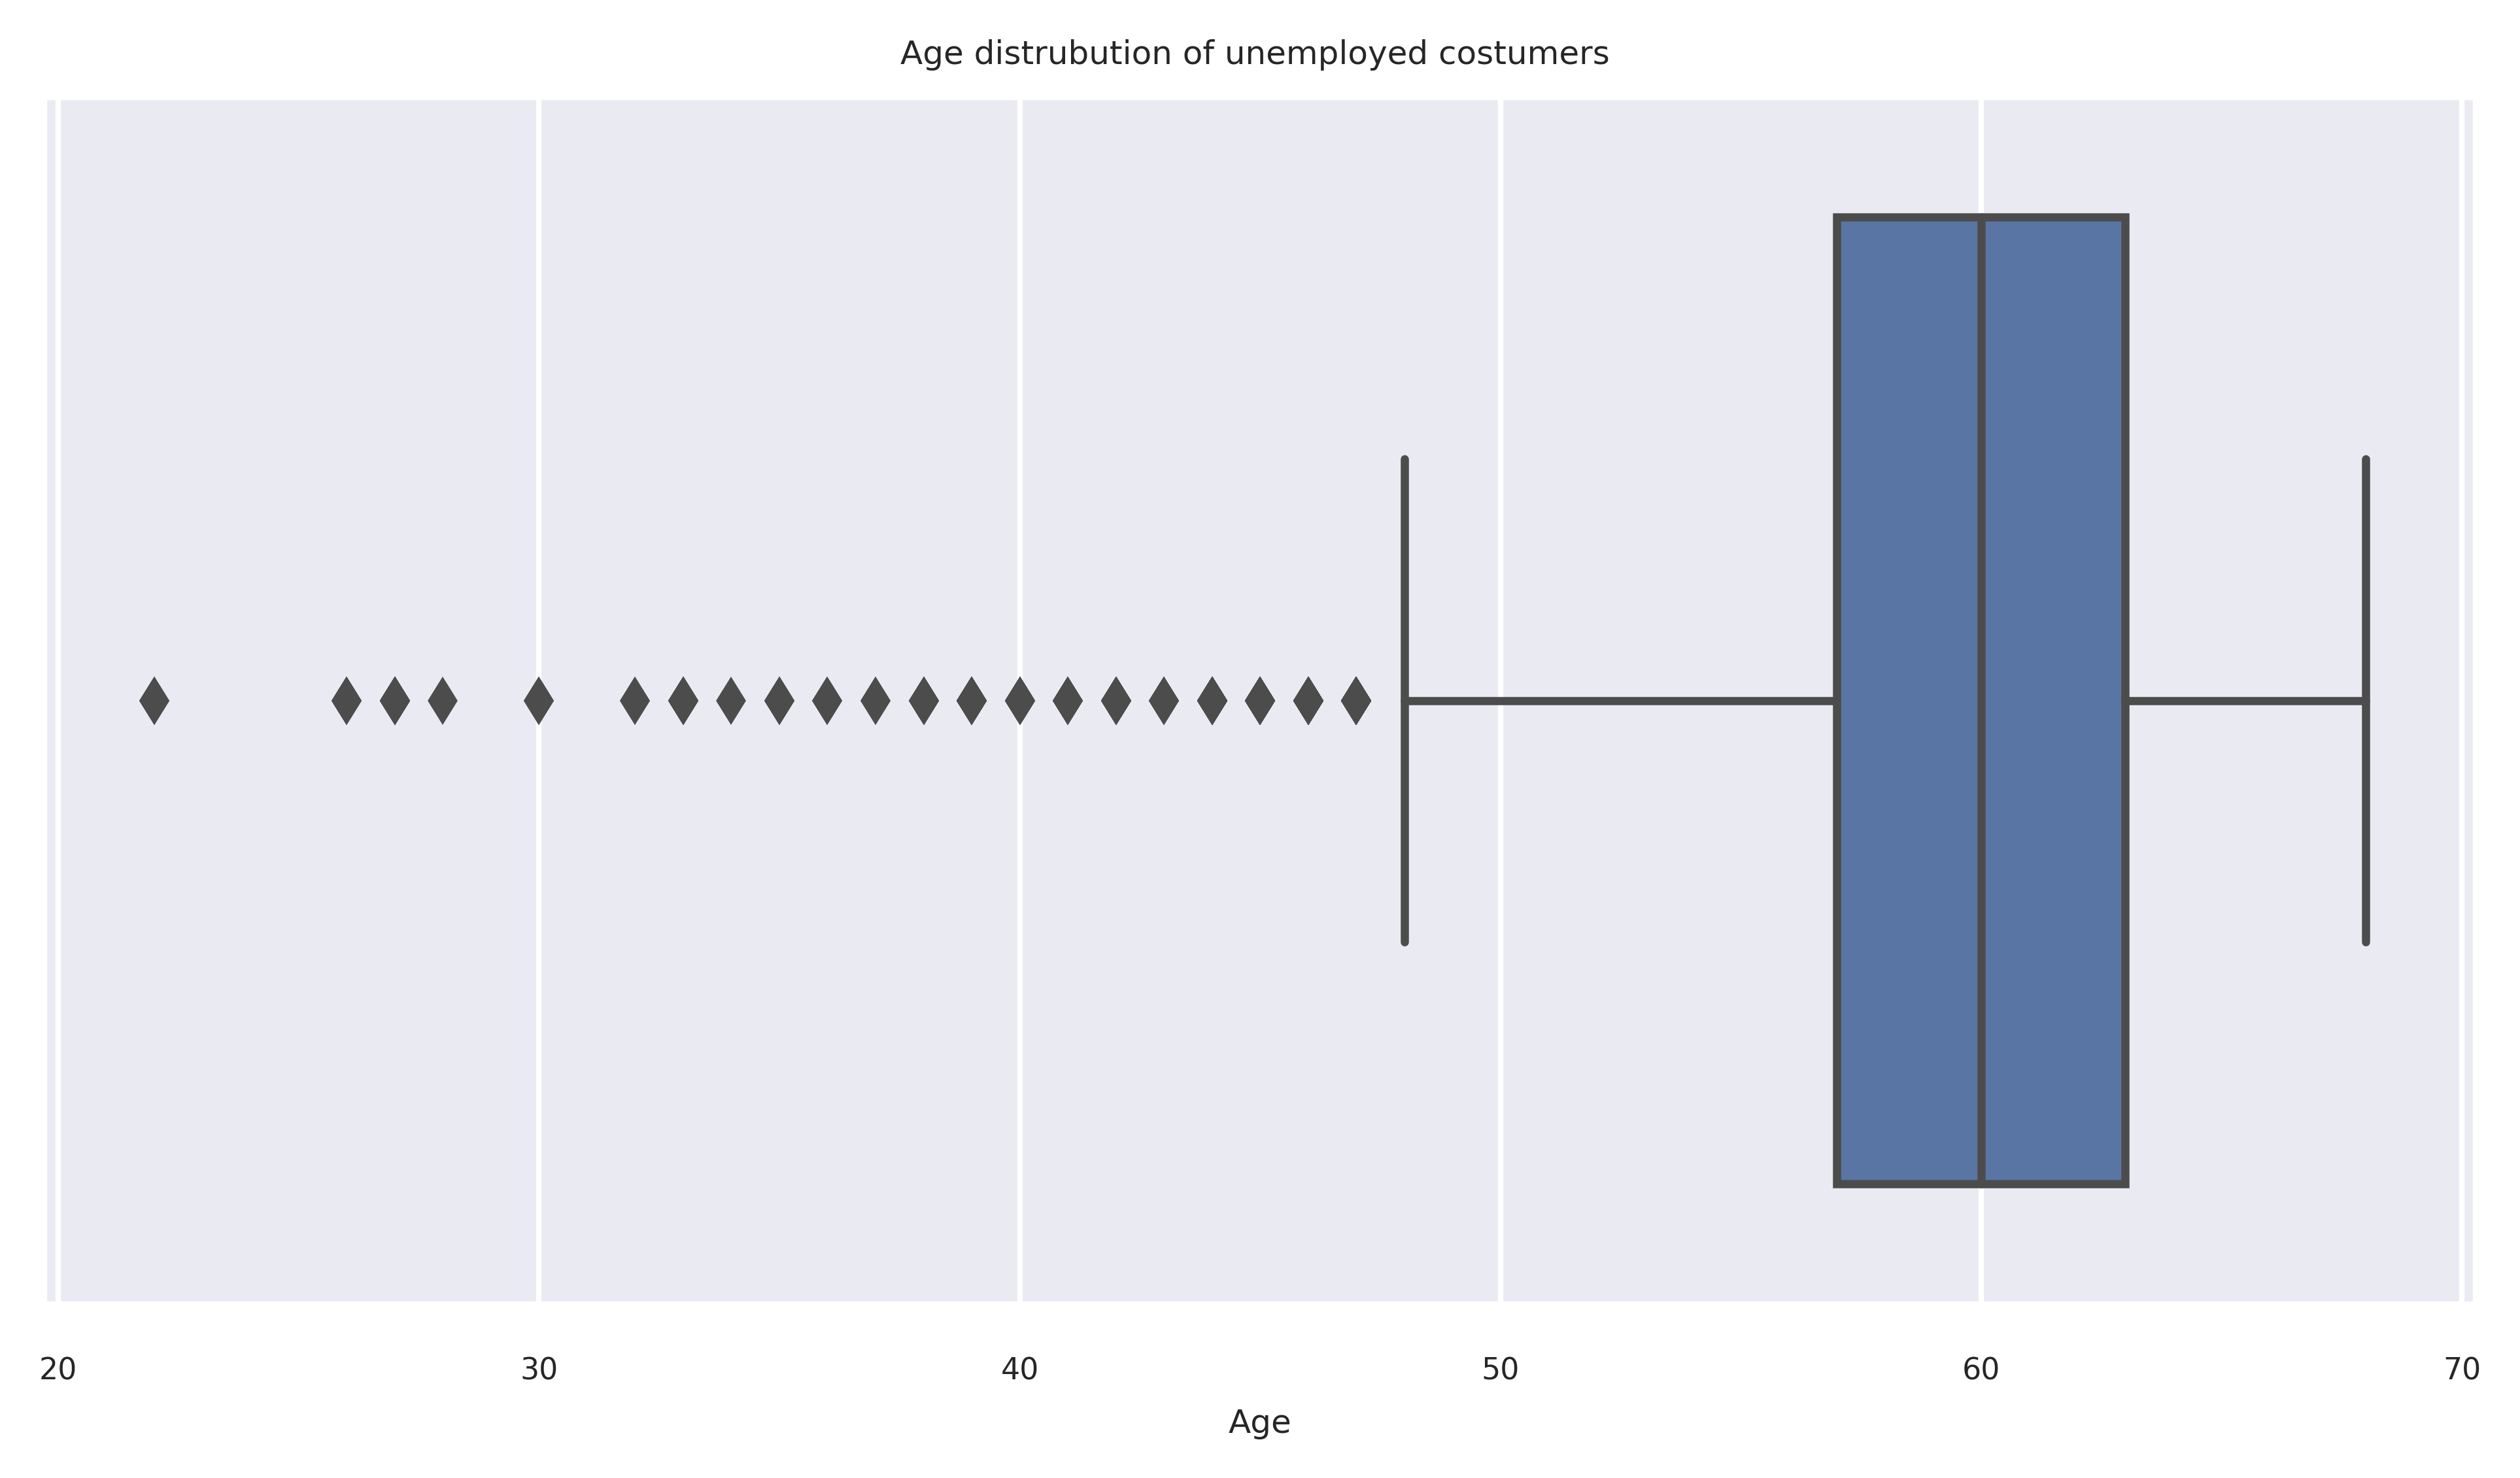

In [355]:

sns.set(rc = {"figure.figsize":(8,4)})
sns.set(font_scale=0.5)
p = sns.boxplot(x=newAppRec[newAppRec.unemployed==1]['age'])
p.set_title("Age distrubution of unemployed costumers ")
p.set_xlabel("Age")

Now it does make sense, because actualy the total income represent their pensions.  and we have outliers that need to be dealt with.

Let's create new variables:  
 - Calculcate household (int)  
 - Average of income by member (int)  
 - categorical combinations  

In [132]:
newAppRec.loc[newAppRec.NAME_INCOME_TYPE=='p','monthEmployed'] = newAppRec.monthEmployed.max() # since now with pension it would confuse the model to make them with zero month of employement

In [133]:
newAppRec = (newAppRec
             .assign(household = lambda x: x.CNT_CHILDREN + x.NAME_FAMILY_STATUS+1)
             .assign(avgIncPerPerson = lambda x: x.AMT_INCOME_TOTAL/x.household ,
                     totalrevenue =  lambda x:(x.monthEmployed/12) * x.AMT_INCOME_TOTAL)
            
            )

In [124]:
newAppRec.head()



CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                                  
5008804            1             1                1             0   
5008805            1             1                1             0   
5008806            1             1                1             0   
5008808            0             0                1             0   
5008809            0             0                1             0   

         AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
ID                                                               
5008804          427500.0                w                   h   
5008805          427500.0                w                   h   
5008806          112500.0                w                   s   
5008808          270000.0                w                   s   
5008809          270000.0                w                   s   

         NAME_FAMILY_STATUS  FLAG_WORK_PHONE  FLAG_PHONE OCCUPATION_TYPE  \
ID                                                                         
5008804                   1                1           0   Not mentioned   
5008805                   1                1           0   Not mentioned   
5008806                   1                0           0  Security staff   
5008808                   0                0           1     Sales staff   
5008809                   0                0           1     Sales staff   

         CNT_FAM_MEMBERS  Target  age  unemployed  monthEmployed  household  \
ID                                                                            
5008804              2.0       0   32           0            151          2   
5008805              2.0       0   32           0            151          2   
5008806              2.0       0   58           0             37          2   
5008808              1.0       0   52           0            101          1   
5008809              1.0       0   52           0            101          1   

         avgIncPerPerson  totalrevenue  
ID                                      
5008804         213750.0     5379375.0  
5008805         213750.0     5379375.0  
5008806          56250.0      346875.0  
5008808         270000.0     2272500.0  
5008809         270000.0     2272500.0

In [410]:
newAppRec.Target.value_counts()

0    35841
1      616
Name: Target, dtype: int64

Wait a second Data is **duplicayed** for different ID. 5008804 is **similair** to 5008805.  
how many duplication do we Have ?   

In [359]:
newAppRec.shape

(36457, 19)

In [370]:
newAppRec.drop_duplicates()

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                                  
5008804            1             1                1             0   
5008806            1             1                1             0   
5008808            0             0                1             0   
5008812            0             0                1             0   
5008815            1             1                1             0   
...              ...           ...              ...           ...   
5149828            1             1                1             0   
5149834            0             0                1             0   
5149838            0             0                1             0   
5150049            0             0                1             0   
5150337            1             0                1             0   

         AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
ID                                                               
5008804          427500.0                w                   h   
5008806          112500.0                w                   s   
5008808          270000.0                w                   s   
5008812          283500.0                p                   h   
5008815          270000.0                w                   h   
...                   ...              ...                 ...   
5149828          315000.0                w                   s   
5149834          157500.0                w                   h   
5149838          157500.0                p                   h   
5150049          283500.0                w                   s   
5150337          112500.0                w                   s   

         NAME_FAMILY_STATUS  FLAG_WORK_PHONE  FLAG_PHONE OCCUPATION_TYPE  \
ID                                                                         
5008804                   1                1           0   Not mentioned   
5008806                   1                0           0  Security staff   
5008808                   0                0           1     Sales staff   
5008812                   0                0           0   Not mentioned   
5008815                   1                1           1     Accountants   
...                     ...              ...         ...             ...   
5149828                   1                0           0        Managers   
5149834                   1                0           1  Medicine staff   
5149838                   1                0           1  Medicine staff   
5150049                   1                0           0     Sales staff   
5150337                   0                0           0        Laborers   

         CNT_FAM_MEMBERS  Target  age  unemployed  monthEmployed  household  \
ID                                                                            
5008804              2.0       0   32           0            151          2   
5008806              2.0       0   58           0             37          2   
5008808              1.0       0   52           0            101          1   
5008812              1.0       0   61           1            523          1   
5008815              2.0       0   46           0             25          2   
...                  ...     ...  ...         ...            ...        ...   
5149828              2.0       1   47           0             80          2   
5149834              2.0       1   33           0             44          2   
5149838              2.0       1   33           0             44          2   
5150049              2.0       1   49           0             21          2   
5150337              1.0       1   25           0             39          1   

         avgIncPerPerson  totalrevenue  
ID                                      
5008804         213750.0     5379375.0  
5008806          56250.0      346875.0  
5008808         270000.0     2272500.0  
5008812         283500.0    12

In [372]:
# 36457 - 9735 = 26722 something is wrong.

In [396]:
newAppRec.sort_index().tail(14)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                                  
5150468            0             0                1             0   
5150473            1             1                1             0   
5150475            1             1                1             0   
5150476            1             1                1             0   
5150477            1             1                1             0   
5150478            1             1                1             0   
5150479            0             0                0             0   
5150480            0             1                1             1   
5150481            0             1                1             1   
5150482            0             1                1             1   
5150483            0             1                1             1   
5150484            0             1                1             1   
5150485            0             1                1             1   
5150487            1             1                0             0   

         AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
ID                                                               
5150468          180000.0                w                   s   
5150473          202500.0                w                   s   
5150475          202500.0                w                   s   
5150476          202500.0                w                   s   
5150477          202500.0                w                   s   
5150478          202500.0                w                   s   
5150479           90000.0                w                   h   
5150480          157500.0                w                   s   
5150481          157500.0                w                   s   
5150482          157500.0                w                   s   
5150483          157500.0                w                   s   
5150484          157500.0                w                   s   
5150485          157500.0                w                   s   
5150487          202500.0                w                   s   

         NAME_FAMILY_STATUS  FLAG_WORK_PHONE  FLAG_PHONE OCCUPATION_TYPE  \
ID                                                                         
5150468                   1                0           0   Cooking staff   
5150473                   1                1           0        Laborers   
5150475                   1                1           0        Laborers   
5150476                   1                1           0        Laborers   
5150477                   1                1           0        Laborers   
5150478                   1                1           0        Laborers   
5150479                   1                0           0   Not mentioned   
5150480                   1                0           0      Core staff   
5150481                   1                0           0      Core staff   
5150482                   1                0           0      Core staff   
5150483                   1                0           0      Core staff   
5150484                   1                0           0      Core staff   
5150485                   1                0           0      Core staff   
5150487                   1                0           0         Drivers   

         CNT_FAM_MEMBERS  Target  age  unemployed  monthEmployed  household  \
ID                                                                            
5150468              2.0       0   48           0             81          2   
5150473              2.0       0   29           0             43          2   
5150475              2.0       0   29           0             43          2   
5150476              2.0       0   29           0             43          2   
5150477              2.0       0   29           0             43          2   
5150478              2.0       0   29           0             43          2  

Let's aggregate on all columns **except** **ID** and **Target**

In [125]:
X_cols = set(newAppRec.columns) - set(['Target'])

In [126]:
newAppRec.sort_index(inplace=True)

In [127]:
L = (newAppRec
     .reset_index()
     .groupby(list(X_cols))
     .agg({'ID':list,'Target':list})
     .reset_index(drop=True)
    )

In [128]:
L['len'] = [len(i) for i in L.Target]
L['var'] = [np.var(i) for i in L.Target]
L['#target'] = [np.sum(i)  for i in L.Target]
L['Diff'] = [np.max(i) -  np.min(i)  for i in L.ID]
L[L['var'] != 0 ]

ID  \
40    [5113920, 5113921, 5113922, 5113923, 5113924, ...   
46    [5048363, 5048364, 5048365, 5048366, 5048367, ...   
67    [5033655, 5117342, 5117344, 5117345, 5117350, ...   
91    [5058345, 5058348, 5058351, 5058352, 5058353, ...   
111   [5021393, 5021394, 5021397, 5021398, 5021399, ...   
...                                                 ...   
9157               [5143086, 5143088, 5143089, 5143090]   
9161                                 [5054279, 5054280]   
9190               [5139572, 5139574, 5139575, 5139576]   
9255  [5042059, 5042060, 5042061, 5042062, 5042063, ...   
9302      [5142239, 5142240, 5142241, 5142242, 5142243]   

                                                Target  len       var  \
40                            [1, 0, 0, 0, 0, 0, 0, 0]    8  0.109375   
46                [1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0]   12  0.243056   
67                [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]   12  0.076389   
91                                  [1, 1, 0, 1, 0, 1]    6  0.222222   
111               [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]   12  0.076389   
...                                                ...  ...       ...   
9157                                      [0, 1, 0, 0]    4  0.187500   
9161                                            [0, 1]    2  0.250000   
9190                                      [0, 1, 0, 0]    4  0.187500   
9255  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   16  0.058594   
9302                                   [1, 1, 0, 0, 0]    5  0.240000   

      #target   Diff  
40          1      7  
46          5     17  
67          1  84313  
91          4      9  
111         1  91742  
...       ...    ...  
9157        1      4  
9161        1      1  
9190        1      4  
9255        1     18  
9302        2      4  

[281 rows x 6 columns]

In [157]:
newAppRec.loc[L.loc[40,"ID"],:]

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                                  
5113920            0             0                0             0   
5113921            0             0                0             0   
5113922            0             0                0             0   
5113923            0             0                0             0   
5113924            0             0                0             0   
5113925            0             0                0             0   
5113926            0             0                0             0   
5113927            0             0                0             0   

         AMT_INCOME_TOTAL NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
ID                                                               
5113920           90000.0                p                   s   
5113921           90000.0                p                   s   
5113922           90000.0                p                   s   
5113923           90000.0                p                   s   
5113924           90000.0                p                   s   
5113925           90000.0                p                   s   
5113926           90000.0                p                   s   
5113927           90000.0                p                   s   

         NAME_FAMILY_STATUS  FLAG_WORK_PHONE  FLAG_PHONE OCCUPATION_TYPE  \
ID                                                                         
5113920                   0                0           0   Not mentioned   
5113921                   0                0           0   Not mentioned   
5113922                   0                0           0   Not mentioned   
5113923                   0                0           0   Not mentioned   
5113924                   0                0           0   Not mentioned   
5113925                   0                0           0   Not mentioned   
5113926                   0                0           0   Not mentioned   
5113927                   0                0           0   Not mentioned   

         CNT_FAM_MEMBERS  Target  age  unemployed  monthEmployed  household  \
ID                                                                            
5113920              1.0       1   64           1            523          1   
5113921              1.0       0   64           1            523          1   
5113922              1.0       0   64           1            523          1   
5113923              1.0       0   64           1            523          1   
5113924              1.0       0   64           1            523          1   
5113925              1.0       0   64           1            523          1   
5113926              1.0       0   64           1            523          1   
5113927              1.0       0   64           1            523          1   

         avgIncPerPerson  totalrevenue  
ID                                      
5113920          90000.0     3922500.0  
5113921          90000.0     3922500.0  
5113922          90000.0     3922500.0  
5113923          90000.0     3922500.0  
5113924          90000.0     3922500.0  
5113925          90000.0     3922500.0  
5113926          90000.0     3922500.0  
5113927          90000.0     3922500.0

At this point they might have the same name and same parents, maybe it's same user with **different account** ?   
Let's go with this theory.

In [134]:
X_cols = set(newAppRec.columns) - set(['Target'])

In [135]:
NewAppRecD =  newAppRec.groupby(list(X_cols)).agg({'Target':"max"}).reset_index() # aggregate on all columns except Target

In [148]:
NewAppRecD.Target.value_counts()

0    9015
1     439
Name: Target, dtype: int64

In [149]:
439/(9015+439) # seems ok 

0.04643537127141951

In [138]:
# Let's do the same process 
cat_columns = [ 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
        'OCCUPATION_TYPE','unemployed']
encoder = ce.WOEEncoder(cols=cat_columns)
encoder.fit(NewAppRecD[cat_columns],NewAppRecD.Target)
WOE = encoder.transform(NewAppRecD[cat_columns])

In [139]:
encoder = ce.TargetEncoder(cols=cat_columns)
encoder.fit(NewAppRecD[cat_columns],NewAppRecD.Target)
TargetEncoded = encoder.transform(NewAppRecD[cat_columns])
encoder = ce.HashingEncoder(cols=cat_columns)
encoder.fit(NewAppRecD[cat_columns],NewAppRecD.Target)
Hashencoded = encoder.transform(NewAppRecD[cat_columns])

/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/hamza/VirtualEnv/Python39-tf/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [140]:
trainingDataset = ((NewAppRecD
                   .drop(columns=['OCCUPATION_TYPE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE'])
                   .merge(WOE,left_index=True, right_index=True))
                   .merge(TargetEncoded,left_index=True, right_index=True)
                   .merge(Hashencoded,left_index=True, right_index=True))

In [141]:
X_col = list(set(trainingDataset.columns) - set(['Target']))

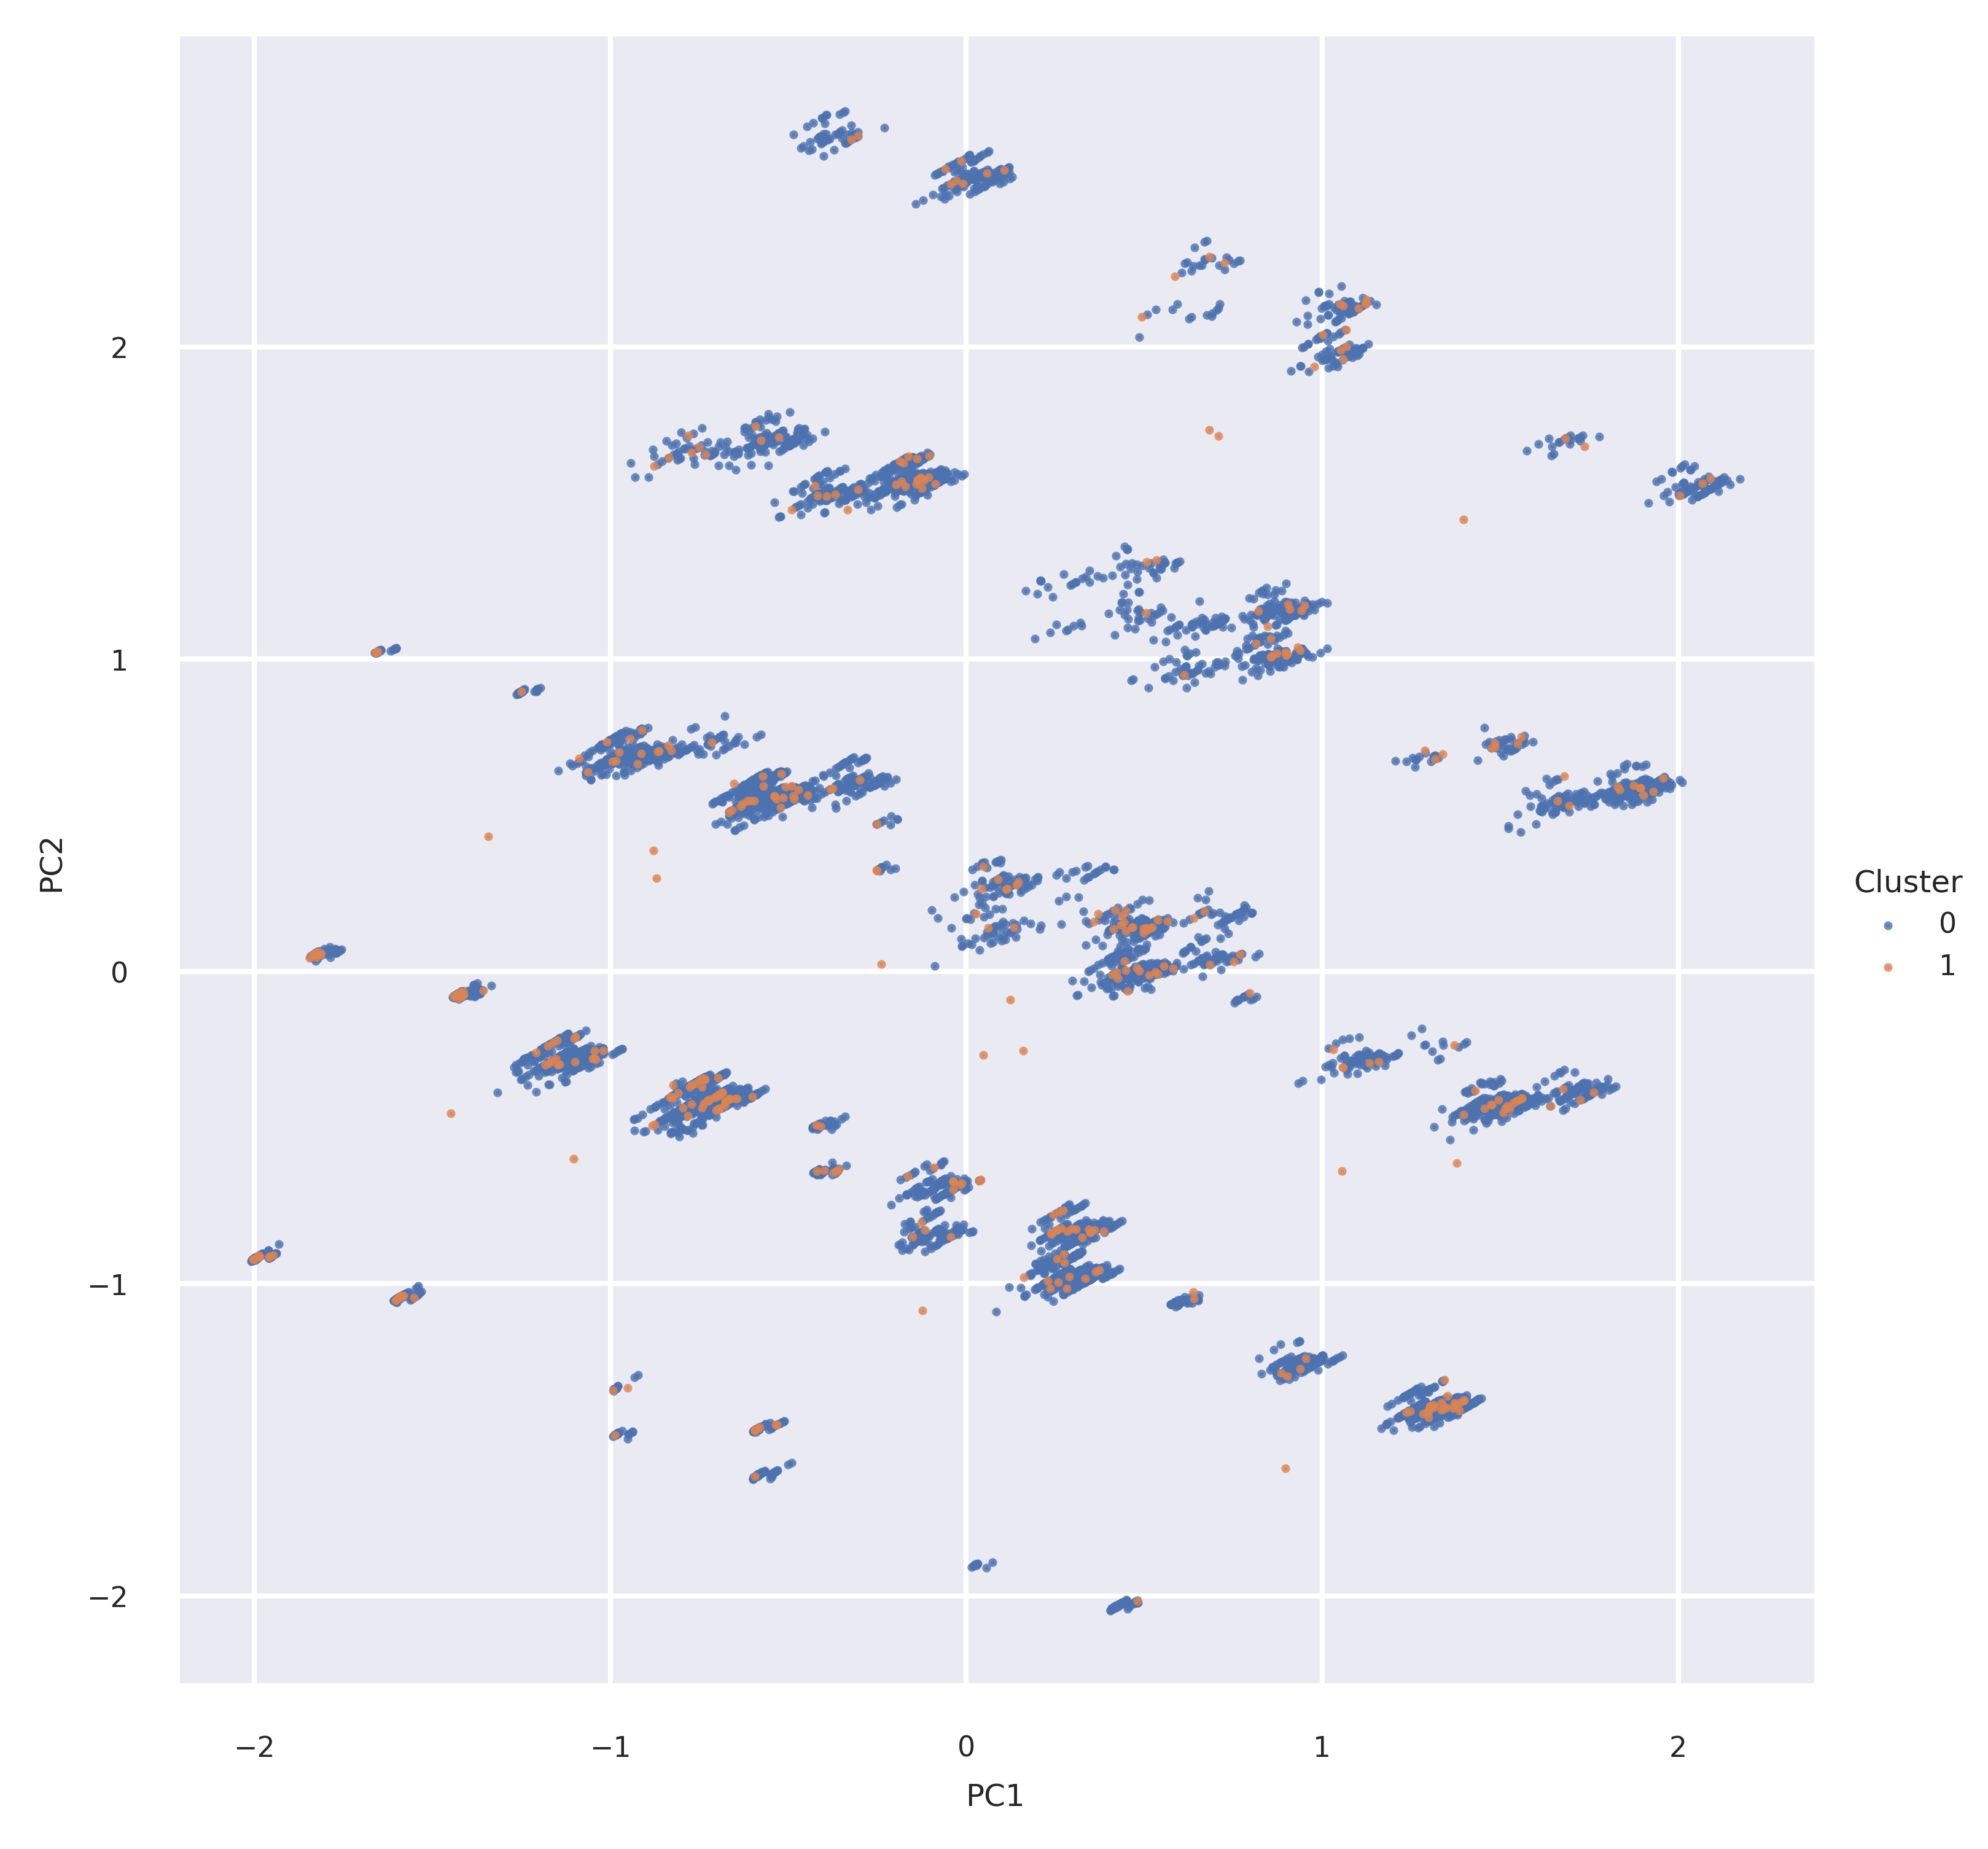

In [142]:
scaler = MinMaxScaler()
X = (scaler.fit_transform(trainingDataset[X_col]))
pca = PCA(n_components=2,whiten=True,svd_solver='arpack')
X_r = pca.fit(X).transform(X)
pc_df = pd.DataFrame(data = X_r , 
        columns = ['PC1', 'PC2'])
pc_df['Cluster'] = trainingDataset.Target.values
sns.set(rc = {"figure.figsize":(10,6)})
sns.set(font_scale=0.5)

sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 0.5}) # specify the point size

In [146]:
NewAppRecD

totalrevenue  FLAG_PHONE  NAME_FAMILY_STATUS  FLAG_OWN_REALTY  \
0              0.0           0                   0                0   
1          11250.0           0                   1                0   
2          11250.0           0                   1                0   
3          15000.0           0                   0                0   
4          15000.0           0                   0                0   
...            ...         ...                 ...              ...   
9449    23535000.0           0                   1                1   
9450    25888500.0           0                   0                0   
9451    27457500.0           1                   0                1   
9452    29418750.0           0                   1                1   
9453    32360625.0           0                   0                1   

     NAME_EDUCATION_TYPE  avgIncPerPerson  CNT_CHILDREN  age  CNT_FAM_MEMBERS  \
0                      s          67500.0             1   37              2.0   
1                      s          15000.0             1   37              3.0   
2                      s          67500.0             0   52              2.0   
3                      s          36000.0             0   40              1.0   
4                      s          90000.0             0   54              1.0   
...                  ...              ...           ...  ...              ...   
9449                   h         270000.0             0   58              2.0   
9450                   h         594000.0             0   47              1.0   
9451                   s         630000.0             0   60              1.0   
9452                   h         337500.0             0   59              2.0   
9453                   h         742500.0             0   59              1.0   

      CODE_GENDER  FLAG_OWN_CAR  FLAG_WORK_PHONE NAME_INCOME_TYPE  \
0               0             0                0                w   
1               0             0                0                w   
2               0             0                0                w   
3               0             0                1                w   
4               0             0                0                w   
...           ...           ...              ...              ...   
9449            0             1                0                p   
9450            0             0                0                p   
9451            0             0                0                p   
9452            0             1                0                p   
9453            0             1                0                p   

      AMT_INCOME_TOTAL  monthEmployed  household        OCCUPATION_TYPE  \
0             135000.0              0          2            Sales staff   
1              45000.0              3          3             Core staff   
2             135000.0              1          2               Laborers   
3              36000.0              5          1         Cleaning staff   
4              90000.0              2          1  High skill tech staff   
...                ...            ...        ...                    ...   
9449          540000.0            523          2          Not mentioned   
9450          594000.0            523          1          Not mentioned   
9451          630000.0            523          1          Not mentioned   
9452          675000.0            523          2          Not mentioned   
9453          742500.0            523          1          Not mentioned   

      unemployed  Target  
0              0       0  
1              0       0  
2              0       0  
3              0       0  
4              0       0  
...          ...     ...  
9449           1       0  
9450           1       0  
9451           1       0  
9452           1       0  
9453           1       0  

[9454 rows x 19 columns]

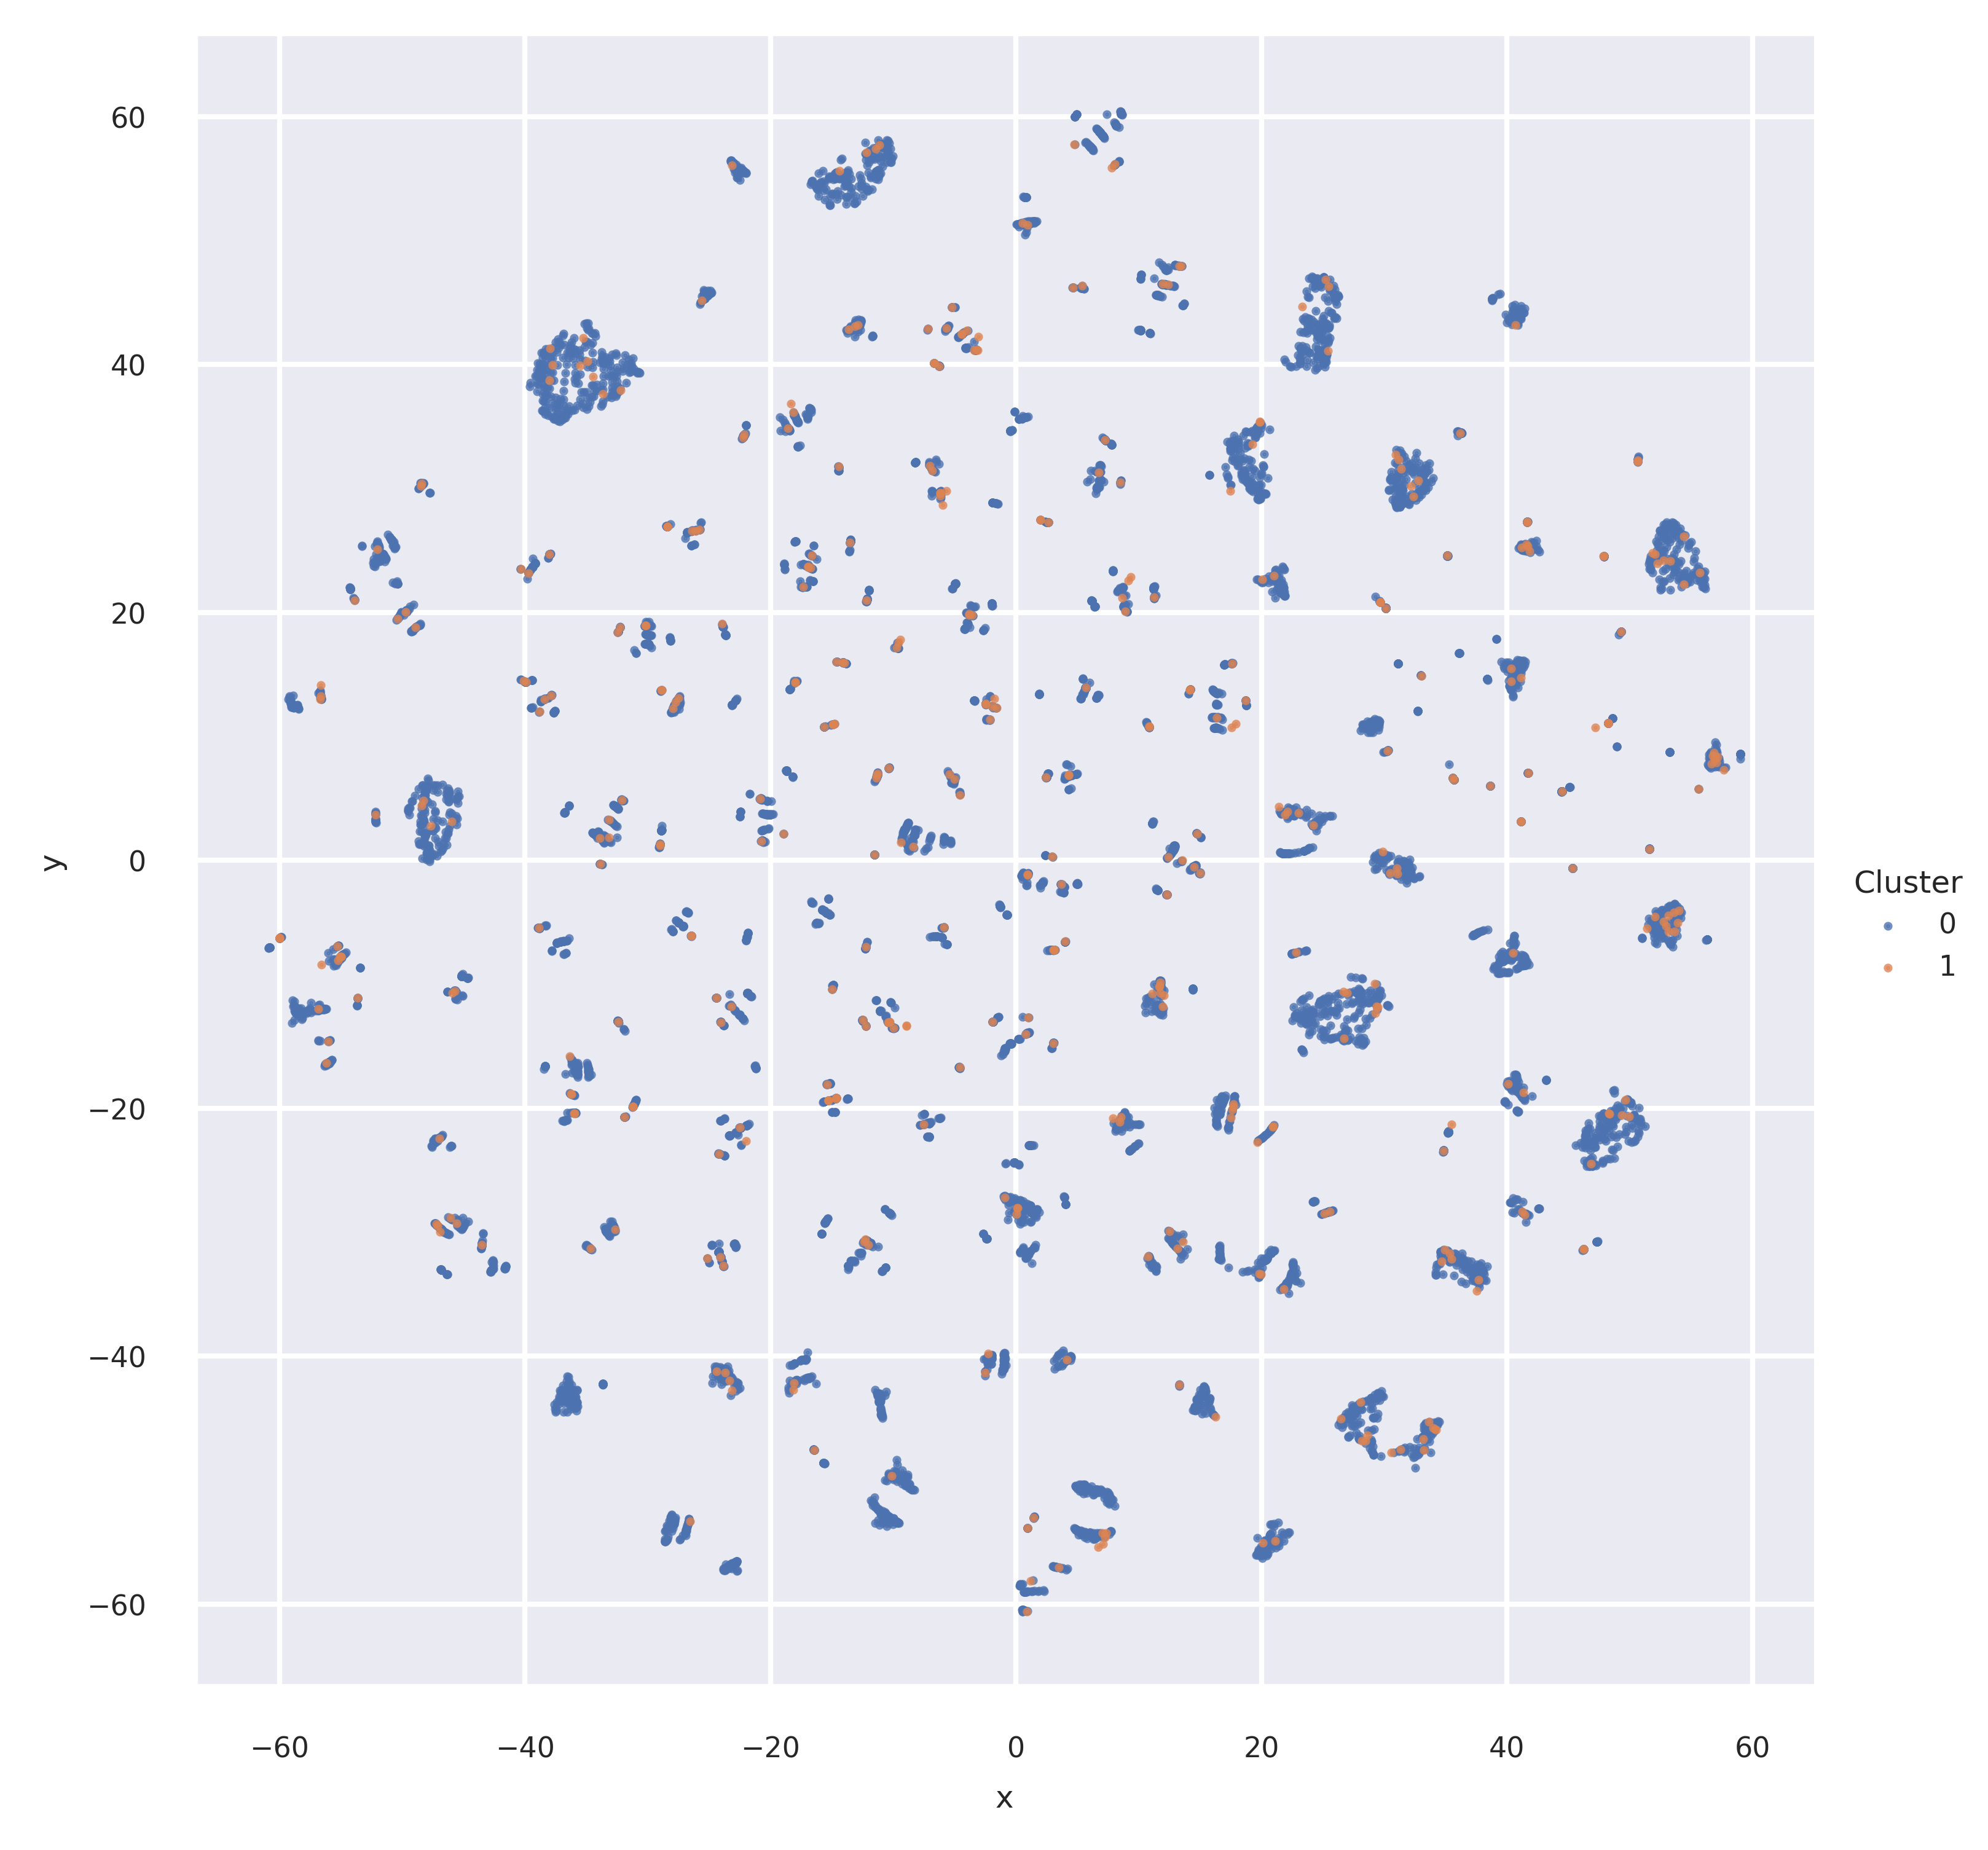

In [147]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=50,early_exaggeration=100).fit_transform(X)
pc_df = pd.DataFrame(data = X_embedded , 
        columns = ['x', 'y'])
pc_df['Cluster'] = trainingDataset.Target.values
sns.set(rc = {"figure.figsize":(10,6)})
sns.set(font_scale=0.5)

sns.lmplot( x="x", y="y",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 0.5}) # specify the point size

**Still overlapping**

At this point it's only worse.  
We have Two choices:  
- Create new combinations of categorical variable, and other variables by introducing some informations from credit Record like number of accounts, make the balancing , remove outliers   and re-do the training.
- Assume that the data was duplicated poorly. 




## Analysing data overlap

let's use ou dataframe L

In [185]:
 (L['#target'].sum())

616

In [161]:
L['Sum0target'] = [len(i)-sum(i) for i in L.Target]

In [163]:
L[L['var']!=0].Sum0target.sum()

1343

In [170]:
L[L['var']!=0]['#target'].sum()

434

It means that 434 ( represening 0.70 %Target == 1) share same information of 1343 Target == 0 which confuse the model. 